In [1]:
import pandas as pd
import matplotlib.pylab as plt
from matplotlib.patches import Ellipse
import matplotlib.lines as lines
from matplotlib import cm
import numpy as np

from sqlalchemy import create_engine, event
import urllib.parse

import seaborn as sns
sns.set()



In [2]:
# SQL database
server = 'CSKMA0400\RDB_Data'
db = 'JLDJobPath'
odbc_connection_string = 'DRIVER={SQL Server Native Client 11.0};SERVER='+server+';DATABASE='+db+';Trusted_Connection=yes'

#Input Tables
flatjld_sql_table = "linkedclaims_casuals_2018m04_v2_flat_20150101_with_income"
clusters_sql_table = "linkedclaims_casuals_2018m04_v2_flat_20150101_with_income_36Vars__7BGM_full_clusters"

# Set to TRUE if you want to 
# normalise variables counting levels with name starting with 'total_duration_days_'
# by variable 'total_duration_days' -- Note: make sure the variables are selected in the variable profile csv file
do_normalize_total_day_counts = True
drop_normalisation_column = True

# Set to TRUE if you want to 
# sum columns and update accordingly the list of lists below, 
# eg Col_A + Col_B and Col_B + Col_C + Col_D: [[Col_A, Col_B], [Col_B, Col_C, Col_D]]
do_sum_columns = False
columns_to_sum = [['Class_A_Earn0','Class_S_Earn0','Class_Other_Earn0'],
                  ['Class_A_Earn1','Class_S_Earn1','Class_Other_Earn1'],
                  ['Class_A_Earn2','Class_S_Earn2','Class_Other_Earn2'],
                  ['Class_A_Earn3','Class_S_Earn3','Class_Other_Earn3'],
                  ['Class_A_Earn4','Class_S_Earn4','Class_Other_Earn4']
                  ]
drop_original_cols = False # Set this to TRUE if you want to drop the cols summed

# Set to TRUE if you want to 
# divide columns and update accordingly the list of lists below, 
# eg Col_A/Col_B and Col_B/Col_C/Col_D: [[Col_A, Col_B], [Col_B, Col_C, Col_D]]
do_divide_columns = True
columns_to_divide = [['Class_A_Earn0','Class_A_weeks0'], 
                     ['Class_A_Earn1','Class_A_weeks1'],
                     ['Class_A_Earn2','Class_A_weeks2'],
                     ['Class_A_Earn3','Class_A_weeks3'], 
                     ['Class_A_Earn4','Class_A_weeks4']]
drop_nominator = True     # Set to TRUE if you want to drop the nominator cols
drop_denominator = False  # Set to TRUE if you want to drop the denominator cols

# Procedure

In [3]:
def read_data_from_sql(sql_table):
    # Connect to SQL
    params = urllib.parse.quote_plus(odbc_connection_string)
    engine = create_engine('mssql+pyodbc:///?odbc_connect=%s' % params)
    conn = engine.connect().connection

    @event.listens_for(engine, 'before_cursor_execute')
    def receive_before_cursor_execute(conn, cursor, statement, params, context, executemany):
        if executemany:
            cursor.fast_executemany = True

    df = pd.read_sql_table(sql_table, engine)
    conn.close()
    return df


def normalize_total_day_counts(df, drop_norm_col = False):
    col_names = df.columns.tolist()
    name_needle = 'total_duration_days_'
    norm_col = 'total_duration_days'

    for col in col_names:
        if name_needle in col:
            df[col] = df[col] / (df[norm_col])
#             df[col] = df[col] / (df[norm_col]+1)
    
    if drop_norm_col == True:
        df.drop(columns=[norm_col], inplace=True)
    return df

def sum_columns(df, columns_to_sum, drop_original_cols = False):
    for columns in columns_to_sum:
        cols_in_dataset = True
        for col in columns:
            if col not in df.columns.tolist():
                cols_in_dataset = False
        if cols_in_dataset:
            myname = '+'.join(columns)
            df[myname] = df[columns[0]]
            for i in range(1, len(columns)):
                df[myname] = df[myname] + df[columns[i]]
    if drop_original_cols:
        to_drop = []
        for columns in columns_to_sum:
            for col in columns:
                to_drop.append(col)
        df.drop(columns=to_drop, inplace=True)

def divide_columns(df, columns_to_divide, drop_nominator = True, drop_denominator = False):
    for columns in columns_to_divide:
        cols_in_dataset = True
        for col in columns:
            if col not in df.columns.tolist():
                cols_in_dataset = False
        if cols_in_dataset:
            myname = '/'.join(columns)
            df[myname] = df[columns[0]]
            for i in range(1, len(columns)):
                df[myname] = df[myname] / (df[columns[i]])
#                 df[myname] = df[myname] / (df[columns[i]] +1)
    
    cols_to_drop = []
    if drop_nominator:
        for cols in columns_to_divide:
            cols_to_drop.append(cols[0])
    if drop_denominator:
        for cols in columns_to_divide:
            cols_to_drop.append(cols[1])
    if len(cols_to_drop) > 0:
        df.drop(columns=cols_to_drop, inplace=True)

print ('Reading Data')
flatjld = read_data_from_sql(flatjld_sql_table)
clusters = read_data_from_sql(clusters_sql_table)

# # filling NA with 0
flatjld.fillna(0, inplace=True)

# Variables Normalization (Total Day Counts)
if do_normalize_total_day_counts:
    print ("Normalizing")
    flatjld = normalize_total_day_counts(flatjld)
    
if do_sum_columns:
    print ('Summing Columns')
    sum_columns(flatjld, columns_to_sum, drop_original_cols)
    
if do_divide_columns:
    print ('Dividing Columns')
    divide_columns(flatjld, columns_to_divide, drop_nominator, drop_denominator)

# Merge flat_jld with clustering info
flatjld= pd.merge(flatjld, clusters, on='ppsn', how='left')


Reading Data
Normalizing
Dividing Columns


# Min/Max LM CODE RANK

In [4]:
pd.crosstab(flatjld['total_min_LM_code_rank'], flatjld['cluster'],  margins=True, normalize='index')

cluster,0,1,2,3,4,5,6
total_min_LM_code_rank,,,,,,,
1.0,0.059502,0.452116,0.211927,0.079710,0.057155,0.046475,0.093115
3.0,0.015856,0.604769,0.135894,0.126615,0.035119,0.043105,0.038642
4.0,0.018607,0.009161,0.555593,0.022704,0.152213,0.029362,0.212359
5.0,0.001171,0.009364,0.958252,0.016387,0.001171,0.012485,0.001171
6.0,0.002825,0.028753,0.861213,0.047715,0.010319,0.026455,0.022720
All,0.049520,0.382092,0.307195,0.073895,0.055448,0.043008,0.088842


In [5]:
pd.crosstab(flatjld['total_min_LM_code_rank'], flatjld['cluster'],  margins=True, normalize='columns')

cluster,0,1,2,3,4,5,6,All
total_min_LM_code_rank,,,,,,,,
1.0,0.967419,0.952669,0.555434,0.868474,0.829906,0.870021,0.843846,0.805120
3.0,0.007544,0.037293,0.010423,0.040372,0.014923,0.023615,0.010248,0.023562
4.0,0.018274,0.001166,0.087960,0.014943,0.133510,0.033202,0.116251,0.048634
5.0,0.000168,0.000174,0.022125,0.001573,0.000150,0.002059,0.000093,0.007093
6.0,0.006594,0.008699,0.324057,0.074639,0.021511,0.071102,0.029561,0.115592


In [6]:
pd.crosstab(flatjld['total_max_LM_code_rank'], flatjld['cluster'],  margins=True, normalize='index')

cluster,0,1,2,3,4,5,6
total_max_LM_code_rank,,,,,,,
3.0,0.044415,0.777557,0.007280,0.055445,0.043974,0.033164,0.038165
4.0,0.030325,0.801036,0.004438,0.010725,0.041790,0.056953,0.054734
5.0,0.057826,0.808790,0.015420,0.029298,0.039322,0.012336,0.037008
6.0,0.049841,0.361542,0.322543,0.075290,0.056070,0.043404,0.091311
All,0.049520,0.382092,0.307195,0.073895,0.055448,0.043008,0.088842


In [7]:
pd.crosstab(flatjld['total_max_LM_code_rank'], flatjld['cluster'],  margins=True, normalize='columns')

cluster,0,1,2,3,4,5,6,All
total_max_LM_code_rank,,,,,,,,
3.0,0.033754,0.076585,0.000892,0.028238,0.029846,0.029020,0.016167,0.037634
4.0,0.004583,0.015688,0.000108,0.001086,0.005640,0.009909,0.004610,0.007483
5.0,0.004191,0.007598,0.000180,0.001423,0.002545,0.001030,0.001495,0.003589
6.0,0.957472,0.900130,0.998820,0.969253,0.961968,0.960041,0.977728,0.951294


# Min/Max Occupation Rank

In [8]:
pd.crosstab(flatjld['total_max_occupation_rank'], flatjld['cluster'], margins=True, normalize='index')

cluster,0,1,2,3,4,5,6
total_max_occupation_rank,,,,,,,
1.0,0.022983,0.079984,0.677027,0.091222,0.056090,0.005973,0.066721
2.0,0.022911,0.200826,0.559187,0.078590,0.047465,0.025042,0.065980
3.0,0.033595,0.340514,0.397128,0.076989,0.053322,0.031495,0.066957
4.0,0.055263,0.433782,0.286951,0.076100,0.058685,0.025367,0.063853
5.0,0.050888,0.432023,0.303174,0.069943,0.049106,0.021163,0.073702
6.0,0.046094,0.371534,0.338712,0.088575,0.043083,0.041941,0.070061
7.0,0.060033,0.442426,0.223684,0.061436,0.064129,0.039978,0.108314
8.0,0.058976,0.375616,0.249726,0.076628,0.068076,0.050082,0.120895
9.0,0.077879,0.428598,0.133888,0.062160,0.068932,0.090429,0.138113


In [9]:
pd.crosstab(flatjld['total_max_occupation_rank'], flatjld['cluster'], margins=True, normalize='columns')

cluster,0,1,2,3,4,5,6,All
total_max_occupation_rank,,,,,,,,
1.0,0.012686,0.005722,0.060241,0.033743,0.027650,0.003796,0.020528,0.027334
2.0,0.028836,0.032759,0.113454,0.066287,0.053354,0.036291,0.046289,0.062327
3.0,0.072427,0.095141,0.138012,0.111228,0.102665,0.078180,0.080460,0.106758
4.0,0.092042,0.093634,0.077042,0.084937,0.087293,0.048646,0.059278,0.082477
5.0,0.130882,0.144008,0.125697,0.120553,0.112797,0.062673,0.105660,0.127364
6.0,0.243769,0.254648,0.288753,0.313909,0.203484,0.255389,0.206523,0.261885
7.0,0.150721,0.143957,0.090527,0.103363,0.143791,0.115565,0.151575,0.124325
8.0,0.048173,0.039763,0.032881,0.041944,0.049661,0.047101,0.055042,0.040448
9.0,0.140103,0.099928,0.038827,0.074938,0.110751,0.187311,0.138492,0.089085


In [10]:
pd.crosstab(flatjld['total_min_occupation_rank'], flatjld['cluster'], margins=True, normalize='index')

cluster,0,1,2,3,4,5,6
total_min_occupation_rank,,,,,,,
1.0,0.051976,0.203322,0.452350,0.097471,0.073472,0.013416,0.107992
2.0,0.046498,0.342302,0.364369,0.081120,0.052720,0.036613,0.076377
3.0,0.051481,0.415119,0.303401,0.070921,0.052281,0.035833,0.070963
4.0,0.064134,0.473595,0.241573,0.067222,0.055755,0.030547,0.067174
5.0,0.051439,0.483507,0.251004,0.063386,0.046481,0.031270,0.072914
6.0,0.034690,0.330538,0.383144,0.090488,0.036932,0.055798,0.068410
7.0,0.054527,0.442608,0.196321,0.050474,0.070663,0.062907,0.122501
8.0,0.046664,0.367864,0.246539,0.075128,0.060818,0.084928,0.118059
9.0,0.059416,0.327029,0.129789,0.060877,0.074026,0.123620,0.225244


# Min/Max Family Flag

In [11]:
pd.crosstab(flatjld['total_min_family_flag_rank'], flatjld['cluster'],  margins=True, normalize='index')

cluster,0,1,2,3,4,5,6
total_min_family_flag_rank,,,,,,,
1.0,0.051364,0.393399,0.287814,0.075268,0.057384,0.042725,0.092045
2.0,0.002072,0.097182,0.812889,0.042064,0.003730,0.038127,0.003937
3.0,0.002690,0.104603,0.739689,0.054094,0.011955,0.073521,0.013449
4.0,0.001502,0.076201,0.842905,0.025526,0.003191,0.046734,0.003941
All,0.049520,0.382092,0.307195,0.073895,0.055448,0.043008,0.088842


In [12]:
pd.crosstab(flatjld['total_min_family_flag_rank'], flatjld['cluster'],  margins=True, normalize='columns')

cluster,0,1,2,3,4,5,6,All
total_min_family_flag_rank,,,,,,,,
1.0,0.998491,0.991128,0.901905,0.980526,0.996257,0.956309,0.997352,0.962640
2.0,0.000559,0.003397,0.035341,0.007602,0.000898,0.011840,0.000592,0.013355
3.0,0.000503,0.002535,0.022296,0.006779,0.001996,0.015829,0.001402,0.009260
4.0,0.000447,0.002941,0.040458,0.005093,0.000848,0.016022,0.000654,0.014745


In [13]:
pd.crosstab(flatjld['total_max_family_flag_rank'], flatjld['cluster'],  margins=True, normalize='index')

cluster,0,1,2,3,4,5,6
total_max_family_flag_rank,,,,,,,
1.0,0.053301,0.360360,0.300293,0.077433,0.062280,0.039721,0.106612
2.0,0.045068,0.436942,0.324260,0.063355,0.040327,0.036287,0.053762
3.0,0.047913,0.375565,0.288340,0.063740,0.061815,0.063386,0.099242
4.0,0.040207,0.421325,0.326456,0.073011,0.039947,0.051091,0.047964
All,0.049520,0.382092,0.307195,0.073895,0.055448,0.043008,0.088842


In [14]:
pd.crosstab(flatjld['total_max_family_flag_rank'], flatjld['cluster'],  margins=True, normalize='columns')

cluster,0,1,2,3,4,5,6,All
total_max_family_flag_rank,,,,,,,,
1.0,0.670504,0.587503,0.608937,0.652760,0.699691,0.575317,0.747531,0.622933
2.0,0.114731,0.144160,0.133066,0.108082,0.091685,0.106364,0.076286,0.126063
3.0,0.068179,0.069262,0.066141,0.060782,0.078559,0.103854,0.078715,0.070466
4.0,0.146585,0.199074,0.191856,0.178376,0.130066,0.214465,0.097468,0.180537


# Min/Max ADA Code

In [15]:
pd.crosstab(flatjld['total_max_ada_code_rank'], flatjld['cluster'],  margins=True, normalize='index')

cluster,0,1,2,3,4,5,6
total_max_ada_code_rank,,,,,,,
1.0,0.056324,0.329386,0.317477,0.090121,0.058670,0.029424,0.118599
2.0,0.044511,0.341397,0.404109,0.067501,0.046407,0.029348,0.066726
3.0,0.048884,0.478877,0.230235,0.047978,0.060652,0.058238,0.075136
4.0,0.042339,0.409808,0.314670,0.067111,0.053335,0.041328,0.071408
5.0,0.033577,0.323718,0.404011,0.071682,0.045602,0.053678,0.067733
6.0,0.049142,0.447761,0.278447,0.083756,0.040733,0.051057,0.049105
7.0,0.029703,0.381188,0.336634,0.056106,0.056931,0.061056,0.078383
8.0,0.050522,0.517693,0.163019,0.038045,0.063612,0.073839,0.093271
9.0,0.043255,0.417857,0.258838,0.070844,0.055733,0.069042,0.084431


In [16]:
pd.crosstab(flatjld['total_max_ada_code_rank'], flatjld['cluster'],  margins=True, normalize='columns')

cluster,0,1,2,3,4,5,6,All
total_max_ada_code_rank,,,,,,,,
1.0,0.462781,0.350752,0.420495,0.496218,0.430525,0.278360,0.543158,0.406877
2.0,0.122052,0.121323,0.178623,0.124036,0.113645,0.092658,0.101984,0.135785
3.0,0.009053,0.011494,0.006874,0.005955,0.010032,0.012419,0.007756,0.009171
4.0,0.074885,0.093939,0.089717,0.079545,0.084248,0.084164,0.070398,0.087585
5.0,0.084106,0.105092,0.163137,0.120328,0.102016,0.154816,0.094571,0.124043
6.0,0.073153,0.086384,0.066817,0.083552,0.054153,0.087510,0.040744,0.073715
7.0,0.002012,0.003346,0.003676,0.002547,0.003444,0.004762,0.002959,0.003354
8.0,0.013804,0.018331,0.007180,0.006966,0.015522,0.023229,0.014204,0.013530
9.0,0.017436,0.021830,0.016819,0.019137,0.020064,0.032044,0.018970,0.019961


In [17]:
pd.crosstab(flatjld['total_min_ada_code_rank'], flatjld['cluster'],  margins=True, normalize='index')

cluster,0,1,2,3,4,5,6
total_min_ada_code_rank,,,,,,,
1.0,0.053057,0.400510,0.273823,0.076144,0.058909,0.042688,0.094868
2.0,0.002058,0.083782,0.841156,0.033905,0.005096,0.026164,0.007839
3.0,0.007874,0.375328,0.430446,0.060367,0.031496,0.076115,0.018373
4.0,0.003342,0.197995,0.654971,0.064745,0.012322,0.057853,0.008772
5.0,0.001547,0.074234,0.824312,0.028457,0.006032,0.057222,0.008197
6.0,0.003367,0.155303,0.702020,0.062710,0.008418,0.060185,0.007997
7.0,0.014706,0.088235,0.897059,0.000000,0.000000,0.000000,0.000000
8.0,0.000000,0.621212,0.181818,0.000000,0.030303,0.151515,0.015152
9.0,0.000000,0.479508,0.192623,0.127049,0.036885,0.147541,0.016393


In [18]:
pd.crosstab(flatjld['total_min_ada_code_rank'], flatjld['cluster'],  margins=True, normalize='columns')

cluster,0,1,2,3,4,5,6,All
total_min_ada_code_rank,,,,,,,,
1.0,0.996256,0.974650,0.828819,0.958130,0.987872,0.922914,0.992898,0.929830
2.0,0.001174,0.006193,0.077330,0.012958,0.002595,0.017180,0.002492,0.028241
3.0,0.000168,0.001036,0.001477,0.000861,0.000599,0.001866,0.000218,0.001054
4.0,0.000894,0.006866,0.028251,0.011610,0.002945,0.017824,0.001308,0.013250
5.0,0.000559,0.003477,0.048016,0.006891,0.001946,0.023808,0.001651,0.017894
6.0,0.000447,0.002673,0.015026,0.005580,0.000998,0.009201,0.000592,0.006575
7.0,0.000056,0.000043,0.000550,0.000000,0.000000,0.000000,0.000000,0.000188
8.0,0.000000,0.000297,0.000108,0.000000,0.000100,0.000643,0.000031,0.000183
9.0,0.000000,0.000847,0.000423,0.001161,0.000449,0.002316,0.000125,0.000675


# Occupation Rank & Median Earnings Per Emp Week Class A by FY

In [19]:
pd.crosstab(flatjld['total_max_occupation_rank'], flatjld['cluster'],values=flatjld['Class_A_Earn0/Class_A_weeks0'], aggfunc=np.median)

cluster,0,1,2,3,4,5,6
total_max_occupation_rank,,,,,,,
1.0,207.625000,223.788462,NaN,193.142857,117.267857,200.102564,169.505747
2.0,223.256410,264.142857,NaN,208.000000,197.761905,357.786437,197.333333
3.0,258.022624,316.393182,50.0,220.890392,259.700000,383.260057,219.088889
4.0,208.096154,241.401923,50.0,208.000000,187.394231,288.353846,188.588235
5.0,208.000000,236.100000,NaN,206.721795,169.826923,236.423469,186.750000
6.0,316.791304,308.666667,0.0,240.829003,253.357692,387.446154,260.314444
7.0,256.740385,288.377500,NaN,208.000000,267.571429,304.500000,221.750000
8.0,281.230769,347.326923,NaN,212.173077,297.395362,418.713629,236.500000
9.0,358.836735,356.066667,NaN,253.461538,362.742308,400.557234,259.700000


In [20]:
pd.crosstab(flatjld['total_max_occupation_rank'], flatjld['cluster'],values=flatjld['Class_A_Earn1/Class_A_weeks1'], aggfunc=np.median)

cluster,0,1,2,3,4,5,6
total_max_occupation_rank,,,,,,,
1.0,189.666667,223.278846,NaN,182.555556,120.736111,292.948718,144.126923
2.0,200.000000,288.326923,47.0,201.989796,240.999316,400.000000,193.977778
3.0,254.000000,341.291667,0.0,233.527778,327.333333,418.423846,233.809211
4.0,211.470571,260.384615,NaN,200.153846,214.173077,297.647059,175.248718
5.0,204.557692,247.019231,0.0,193.985714,187.200000,253.140000,173.888889
6.0,320.780220,323.855769,0.0,270.000000,279.365385,401.192308,259.265306
7.0,268.310729,310.909091,NaN,229.375000,348.884615,332.788462,221.933333
8.0,258.807692,377.940191,NaN,229.000000,368.882353,491.711538,224.038462
9.0,354.423077,371.456522,NaN,292.000000,434.392857,417.050000,254.345760


In [21]:
pd.crosstab(flatjld['total_max_occupation_rank'], flatjld['cluster'],values=flatjld['Class_A_Earn2/Class_A_weeks2'], aggfunc=np.median)

cluster,0,1,2,3,4,5,6
total_max_occupation_rank,,,,,,,
1.0,173.844444,214.166667,NaN,NaN,194.687500,325.100000,78.500000
2.0,189.562500,277.746429,NaN,NaN,355.769231,418.673077,184.282833
3.0,230.279167,339.730556,57.5,0.003333,408.634615,425.000000,211.383333
4.0,200.033333,263.045455,NaN,NaN,270.333333,337.340000,165.114927
5.0,196.267628,247.545455,52.0,0.000000,255.538390,291.213969,165.142857
6.0,303.690045,322.333333,NaN,208.000000,332.560000,394.313725,246.682479
7.0,244.178571,312.971154,NaN,NaN,396.807692,337.192308,225.071429
8.0,231.250000,359.784341,NaN,NaN,418.644231,516.304348,226.487179
9.0,328.000000,364.011628,NaN,NaN,475.704751,429.514286,267.442308


In [22]:
pd.crosstab(flatjld['total_max_occupation_rank'], flatjld['cluster'],values=flatjld['Class_A_Earn3/Class_A_weeks3'], aggfunc=np.median)

cluster,0,1,2,3,4,5,6
total_max_occupation_rank,,,,,,,
1.0,145.992647,224.777778,NaN,NaN,308.115385,289.457168,154.250000
2.0,192.932692,303.550481,40.500000,NaN,408.634167,438.246923,208.000000
3.0,282.740385,362.583333,19.444444,NaN,461.076923,446.358516,257.350000
4.0,192.923077,276.807692,NaN,NaN,296.509615,325.934389,165.670673
5.0,197.096154,260.074176,34.800000,NaN,276.769231,304.805385,177.814103
6.0,318.125000,341.500000,38.000000,NaN,359.250000,417.653846,265.292308
7.0,256.683333,325.000000,NaN,2.0,407.692308,344.762542,257.961538
8.0,239.125000,362.571429,NaN,NaN,448.222222,507.181818,254.525000
9.0,315.034483,367.181319,NaN,NaN,476.442308,426.428571,310.771429


In [23]:
pd.crosstab(flatjld['total_max_occupation_rank'], flatjld['cluster'],values=flatjld['Class_A_Earn4/Class_A_weeks4'], aggfunc=np.median)

cluster,0,1,2,3,4,5,6
total_max_occupation_rank,,,,,,,
1.0,132.093023,271.666667,191.191176,NaN,317.968750,303.785714,150.833333
2.0,222.432692,340.201923,296.000000,NaN,470.673077,455.000000,237.803922
3.0,351.000000,395.586538,375.902924,NaN,498.633333,475.519231,335.192308
4.0,216.000000,293.372093,271.316998,0.25,314.817308,347.173077,189.200000
5.0,200.714286,275.400000,217.416667,3.50,301.706448,324.320000,196.666667
6.0,360.338462,372.589744,359.319444,0.01,395.944444,444.115385,284.522222
7.0,291.679110,343.357143,319.888889,NaN,429.500000,368.461538,299.307051
8.0,275.480057,380.750000,339.636364,NaN,467.343699,552.721154,301.576923
9.0,319.000000,377.797727,355.250000,NaN,489.923077,444.548387,352.261312


# Occupation Rank & Median Emp Week Class A by FY

In [24]:
pd.crosstab(flatjld['total_max_occupation_rank'], flatjld['cluster'],values=flatjld['Class_A_weeks0'], aggfunc=np.median)

cluster,0,1,2,3,4,5,6
total_max_occupation_rank,,,,,,,
1.0,0.0,1.0,0.0,4.0,0.0,0.0,0.0
2.0,1.0,15.0,0.0,9.0,0.0,0.0,0.0
3.0,6.0,19.0,0.0,14.0,0.0,0.0,0.0
4.0,10.0,23.0,0.0,11.0,1.0,0.0,0.0
5.0,14.0,30.0,0.0,15.0,6.0,0.0,0.0
6.0,11.0,21.0,0.0,15.0,0.0,0.0,0.0
7.0,13.0,24.0,0.0,10.0,2.0,0.0,0.0
8.0,7.0,17.0,0.0,6.0,0.0,0.0,0.0
9.0,21.0,27.0,0.0,4.0,17.0,1.0,0.0


In [25]:
pd.crosstab(flatjld['total_max_occupation_rank'], flatjld['cluster'],values=flatjld['Class_A_weeks1'], aggfunc=np.median)

cluster,0,1,2,3,4,5,6
total_max_occupation_rank,,,,,,,
1.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0
2.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0
3.0,1.0,26.0,0.0,0.0,0.0,0.0,0.0
4.0,9.0,34.0,0.0,0.0,1.0,0.0,0.0
5.0,11.0,35.0,0.0,0.0,4.0,0.0,0.0
6.0,6.0,22.0,0.0,0.0,0.0,0.0,0.0
7.0,10.0,32.0,0.0,0.0,8.0,2.0,0.0
8.0,7.0,27.0,0.0,0.0,0.0,0.0,0.0
9.0,20.0,34.0,0.0,0.0,26.0,2.0,0.0


In [26]:
pd.crosstab(flatjld['total_max_occupation_rank'], flatjld['cluster'],values=flatjld['Class_A_weeks2'], aggfunc=np.median)

cluster,0,1,2,3,4,5,6
total_max_occupation_rank,,,,,,,
1.0,0.0,13.0,0.0,0.0,0.0,0.0,0.0
2.0,0.0,33.0,0.0,0.0,0.0,0.0,0.0
3.0,3.0,37.0,0.0,0.0,0.0,0.0,0.0
4.0,10.0,43.0,0.0,0.0,0.0,0.0,0.0
5.0,16.0,42.0,0.0,0.0,8.0,0.0,0.0
6.0,5.0,30.0,0.0,0.0,0.0,0.0,0.0
7.0,14.0,40.5,0.0,0.0,24.0,10.0,0.0
8.0,9.0,36.0,0.0,0.0,6.0,0.0,0.0
9.0,22.0,38.0,0.0,0.0,38.0,9.0,0.0


In [27]:
pd.crosstab(flatjld['total_max_occupation_rank'], flatjld['cluster'],values=flatjld['Class_A_weeks3'], aggfunc=np.median)

cluster,0,1,2,3,4,5,6
total_max_occupation_rank,,,,,,,
1.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0
2.0,0.0,31.0,0.0,0.0,0.0,0.0,0.0
3.0,2.0,38.0,0.0,0.0,0.0,0.0,0.0
4.0,8.0,47.0,0.0,0.0,0.0,0.0,0.0
5.0,12.0,42.0,0.0,0.0,3.0,0.0,0.0
6.0,4.0,27.0,0.0,0.0,0.0,0.0,0.0
7.0,13.0,42.0,0.0,0.0,29.0,12.5,0.0
8.0,8.0,38.0,0.0,0.0,5.0,0.0,0.0
9.0,23.0,39.0,0.0,0.0,41.0,10.0,0.0


In [28]:
pd.crosstab(flatjld['total_max_occupation_rank'], flatjld['cluster'],values=flatjld['Class_A_weeks4'], aggfunc=np.median)

cluster,0,1,2,3,4,5,6
total_max_occupation_rank,,,,,,,
1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2.0,0.0,30.0,0.0,0.0,0.0,0.0,0.0
3.0,2.0,41.0,0.0,0.0,0.0,0.0,0.0
4.0,6.0,49.0,0.0,0.0,0.0,0.0,0.0
5.0,9.0,43.0,0.0,0.0,0.0,0.0,0.0
6.0,3.0,28.0,0.0,0.0,0.0,0.0,0.0
7.0,14.0,45.0,0.0,0.0,31.0,13.0,0.0
8.0,10.0,39.0,0.0,0.0,6.0,0.0,0.0
9.0,21.0,39.0,0.0,0.0,40.0,9.0,0.0


# Occupation Rank & Median Earnings Class S by FY

In [29]:
pd.crosstab(flatjld['total_max_occupation_rank'], flatjld['cluster'],values=flatjld['Class_S_Earn0'], aggfunc=np.median)

cluster,0,1,2,3,4,5,6
total_max_occupation_rank,,,,,,,
1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
pd.crosstab(flatjld['total_max_occupation_rank'], flatjld['cluster'],values=flatjld['Class_S_Earn1'], aggfunc=np.median)

cluster,0,1,2,3,4,5,6
total_max_occupation_rank,,,,,,,
1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Occupation Rank & Median Earnings Other by FY

In [31]:
pd.crosstab(flatjld['total_max_occupation_rank'], flatjld['cluster'],values=flatjld['Class_Other_Earn0'], aggfunc=np.median)

cluster,0,1,2,3,4,5,6
total_max_occupation_rank,,,,,,,
1.0,0.0,0.0,0.0,0.0,829.000,0.0,0.0
2.0,0.0,0.0,0.0,0.0,1122.350,0.0,0.0
3.0,0.0,0.0,0.0,0.0,1117.200,0.0,0.0
4.0,0.0,0.0,0.0,0.0,960.000,0.0,0.0
5.0,0.0,0.0,0.0,0.0,1084.255,0.0,0.0
6.0,0.0,0.0,0.0,0.0,1119.700,0.0,0.0
7.0,0.0,0.0,0.0,0.0,1611.000,0.0,833.0
8.0,0.0,0.0,0.0,0.0,1528.000,0.0,0.0
9.0,0.0,0.0,0.0,0.0,1500.000,0.0,16984.0


In [32]:
pd.crosstab(flatjld['total_max_occupation_rank'], flatjld['cluster'],values=flatjld['Class_Other_Earn1'], aggfunc=np.median)

cluster,0,1,2,3,4,5,6
total_max_occupation_rank,,,,,,,
1.0,0.0,0.0,0.0,0.0,42.145,0.0,0.000
2.0,0.0,0.0,0.0,0.0,77.000,0.0,389.000
3.0,0.0,0.0,0.0,0.0,0.000,0.0,502.000
4.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000
5.0,0.0,0.0,0.0,0.0,58.000,0.0,502.000
6.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000
7.0,0.0,0.0,0.0,0.0,0.000,0.0,2908.615
8.0,0.0,0.0,0.0,0.0,125.000,0.0,2220.000
9.0,0.0,0.0,0.0,0.0,0.000,0.0,20156.000


In [33]:
pd.crosstab(flatjld['total_max_occupation_rank'], flatjld['cluster'],values=flatjld['Class_Other_Earn2'], aggfunc=np.median)

cluster,0,1,2,3,4,5,6
total_max_occupation_rank,,,,,,,
1.0,0.0,0.0,0.0,0.0,0.0,0.0,1160.000
2.0,0.0,0.0,0.0,0.0,0.0,0.0,1871.995
3.0,0.0,0.0,0.0,0.0,0.0,0.0,1892.000
4.0,0.0,0.0,0.0,0.0,0.0,0.0,1373.890
5.0,0.0,0.0,0.0,0.0,0.0,0.0,2326.000
6.0,0.0,0.0,0.0,0.0,0.0,0.0,1040.000
7.0,0.0,0.0,0.0,0.0,0.0,0.0,3957.180
8.0,0.0,0.0,0.0,0.0,0.0,0.0,3644.150
9.0,0.0,0.0,0.0,0.0,0.0,0.0,19776.000


In [34]:
pd.crosstab(flatjld['total_max_occupation_rank'], flatjld['cluster'],values=flatjld['Class_Other_Earn3'], aggfunc=np.median)

cluster,0,1,2,3,4,5,6
total_max_occupation_rank,,,,,,,
1.0,0.0,0.0,0.0,0.0,0.0,0.0,430.550
2.0,0.0,0.0,0.0,0.0,0.0,0.0,1316.000
3.0,0.0,0.0,0.0,0.0,0.0,0.0,1351.000
4.0,0.0,0.0,0.0,0.0,0.0,0.0,883.000
5.0,0.0,0.0,0.0,0.0,0.0,0.0,1825.825
6.0,0.0,0.0,0.0,0.0,0.0,0.0,949.150
7.0,0.0,0.0,0.0,0.0,0.0,0.0,3014.800
8.0,0.0,0.0,0.0,0.0,0.0,0.0,2709.120
9.0,0.0,0.0,0.0,0.0,0.0,0.0,20365.000


# Occupation Rank & Median Duration last episode

In [35]:
pd.crosstab(flatjld['total_max_occupation_rank'], flatjld['cluster'],values=flatjld['duration_days_0'], aggfunc=np.median)

cluster,0,1,2,3,4,5,6
total_max_occupation_rank,,,,,,,
1.0,215.0,304.0,517.0,121.0,228.5,463.0,604.0
2.0,224.0,442.0,1583.0,160.0,211.0,489.0,696.0
3.0,254.0,352.0,1865.0,164.0,248.0,358.0,715.0
4.0,222.0,329.0,1186.0,143.0,207.0,345.5,533.0
5.0,238.0,297.0,1274.0,131.0,192.0,317.0,542.0
6.0,220.0,317.0,1808.0,164.0,255.0,318.0,564.5
7.0,210.0,232.0,1564.0,137.0,185.0,331.0,582.0
8.0,192.0,211.0,1278.0,136.0,198.0,306.0,584.0
9.0,129.0,128.0,1156.0,113.0,149.0,267.0,645.5


# Occupation Rank & Median Age

In [36]:
pd.crosstab(flatjld['total_max_occupation_rank'], flatjld['cluster'],values=flatjld['age'], aggfunc=np.median)

cluster,0,1,2,3,4,5,6
total_max_occupation_rank,,,,,,,
1.0,22.0,27.0,22.0,21.0,20.0,46.0,22.0
2.0,25.0,38.0,36.0,25.0,23.0,49.0,25.0
3.0,33.0,39.0,41.0,32.0,38.0,50.0,45.0
4.0,26.0,33.0,34.0,25.0,27.0,50.0,27.0
5.0,31.0,36.0,42.0,30.0,34.0,47.0,38.0
6.0,32.0,38.0,41.0,35.0,37.0,46.0,32.0
7.0,37.0,39.0,42.0,35.0,44.0,53.0,55.0
8.0,33.0,36.0,41.0,32.0,39.0,49.0,45.0
9.0,35.0,39.0,42.0,33.0,46.0,53.0,60.0


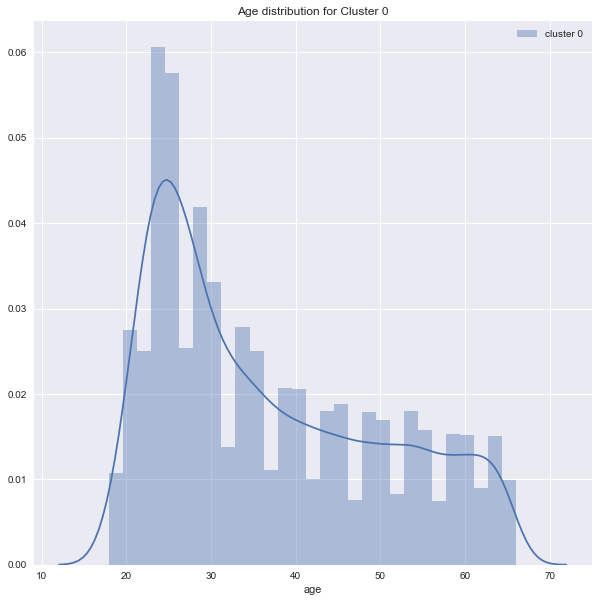

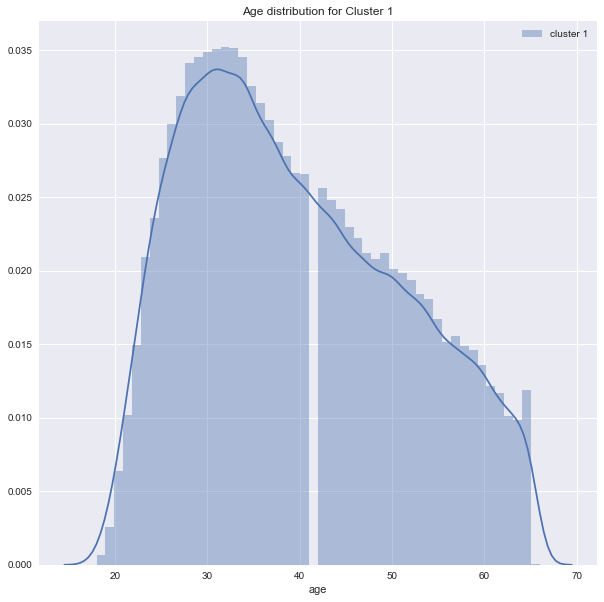

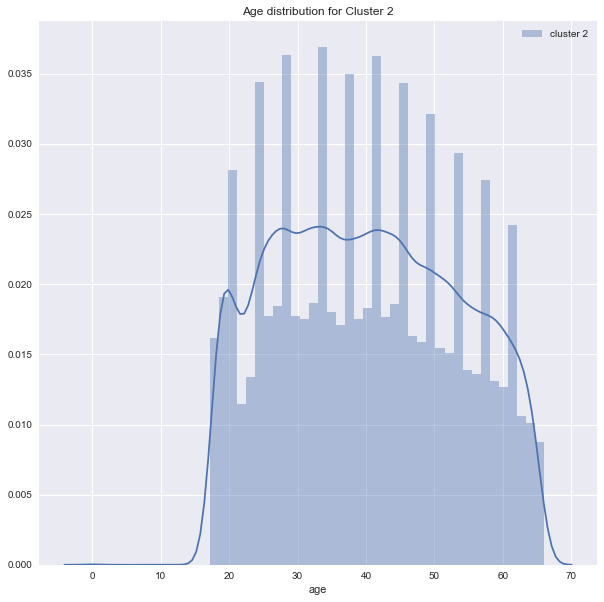

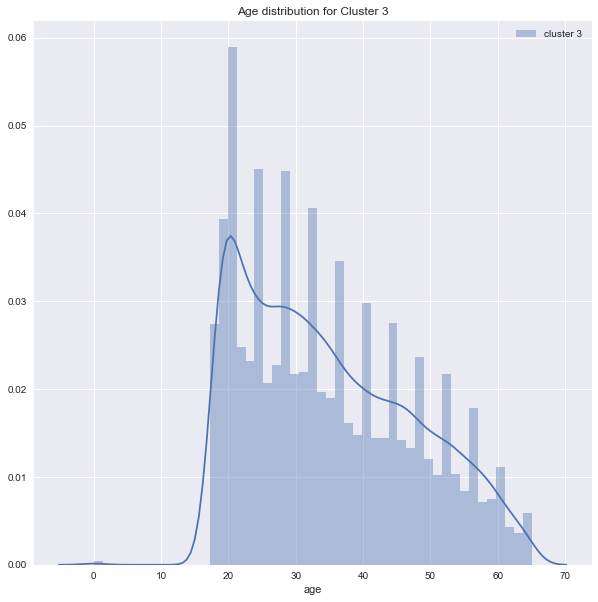

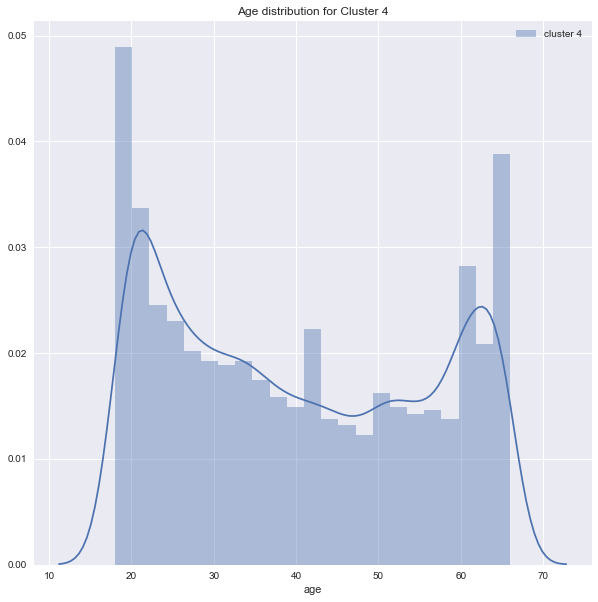

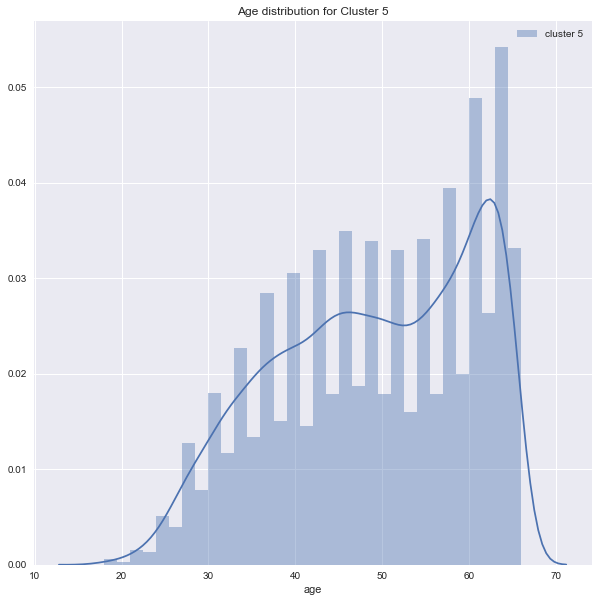

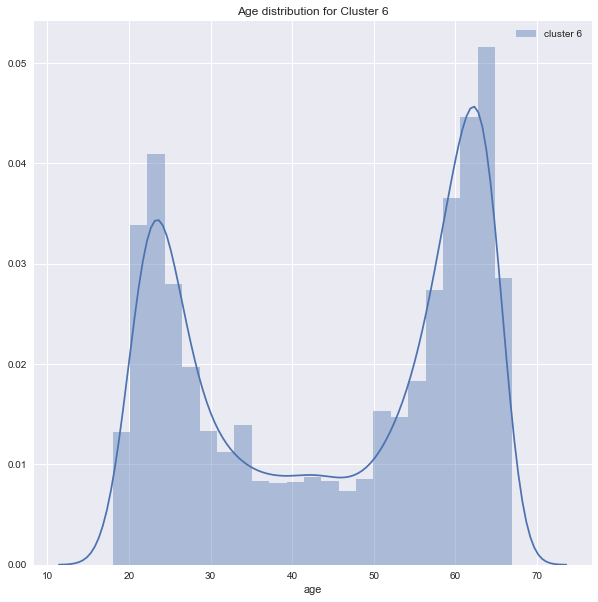

In [37]:
clusters = flatjld.cluster.unique()
clusters.sort()

for c in clusters:
    data = flatjld.loc[flatjld['cluster']  == c]['age']
    plt.figure(figsize=(10,10))
    sns.distplot(data, label='cluster '+str(c))
    plt.title('Age distribution for Cluster ' + str(c))
    plt.legend()
    plt.show()

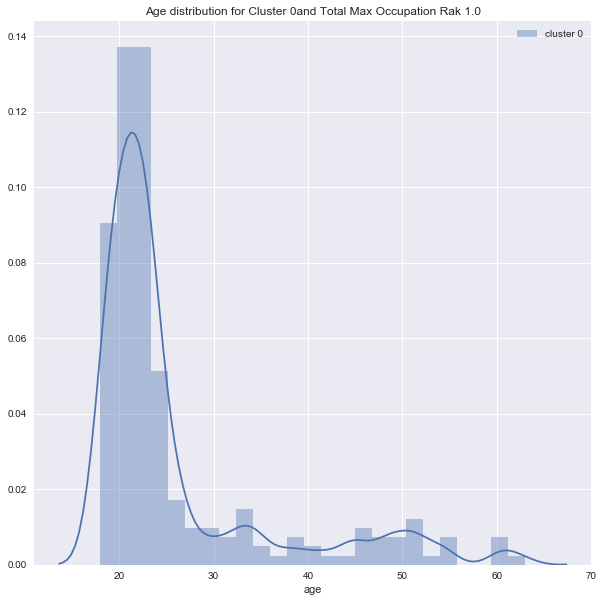

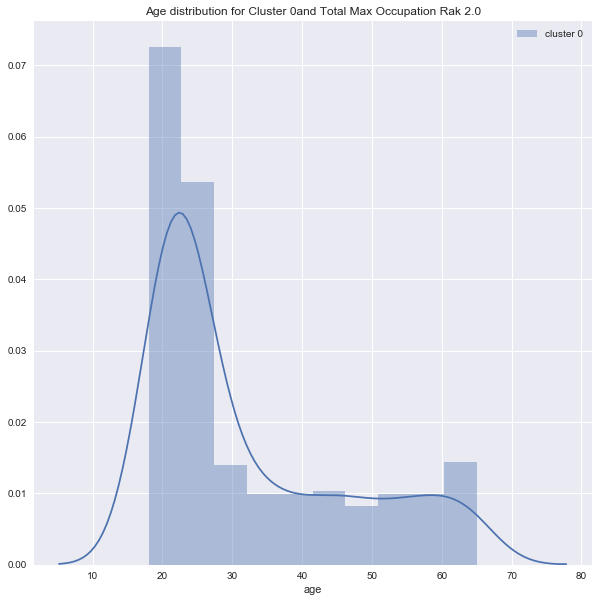

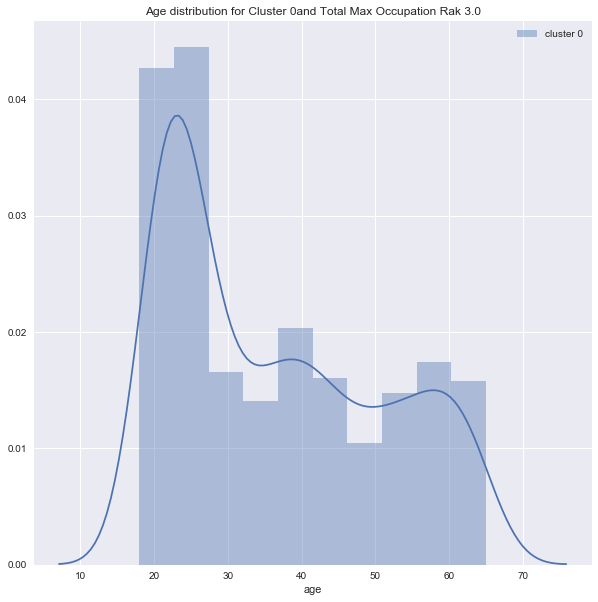

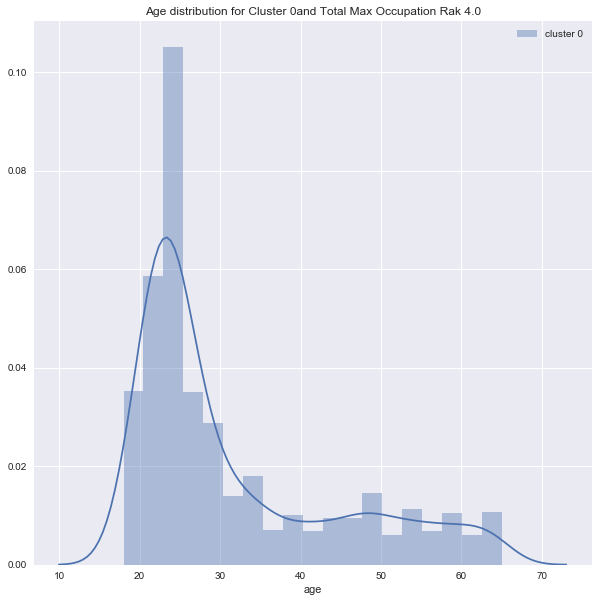

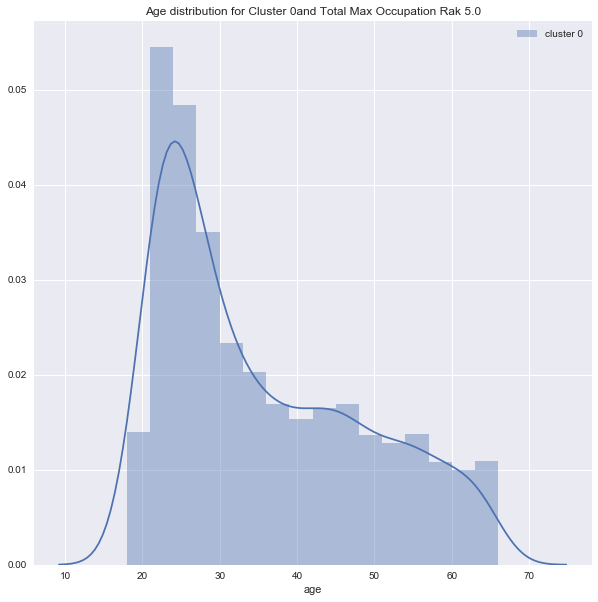

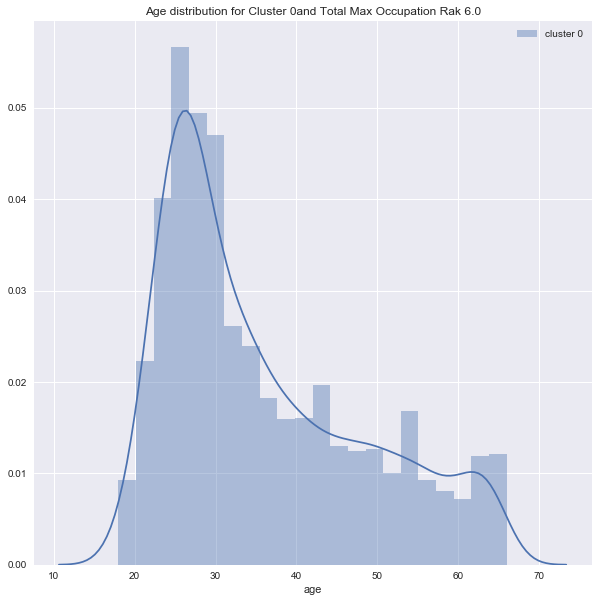

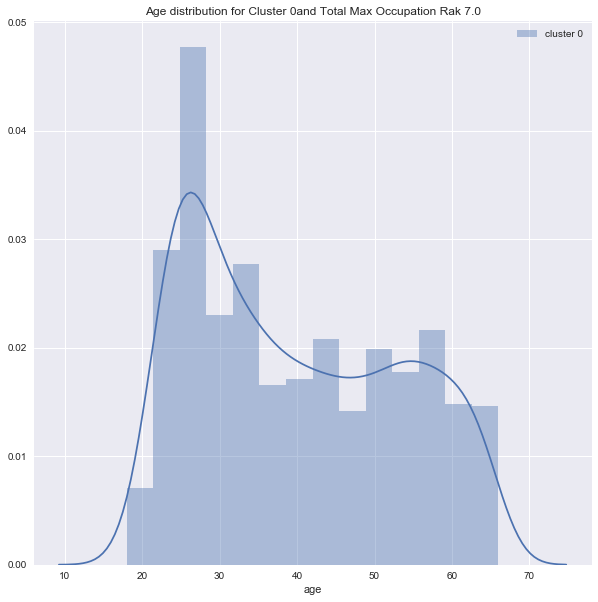

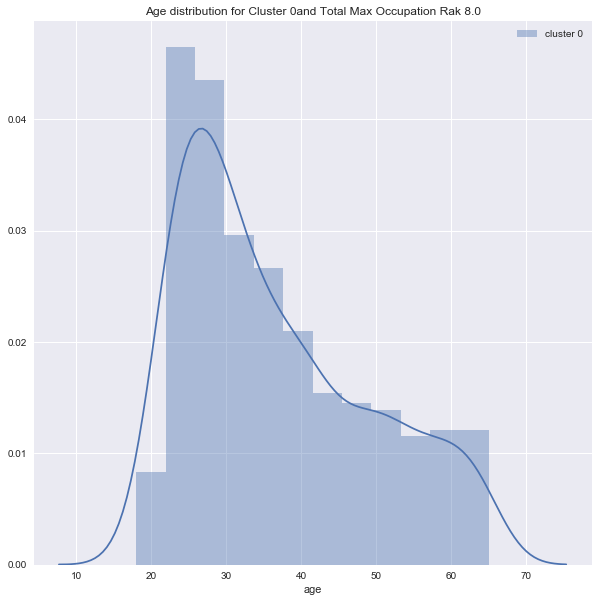

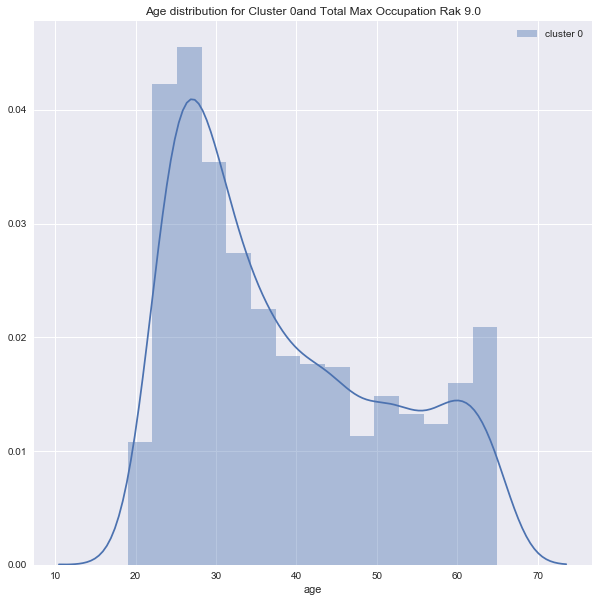

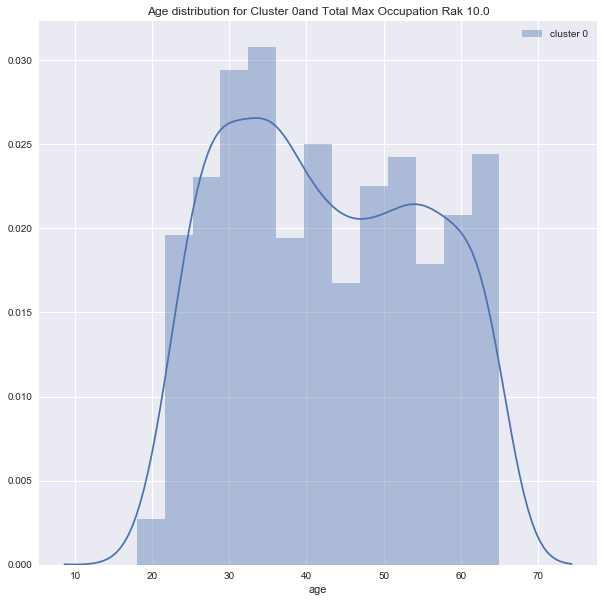

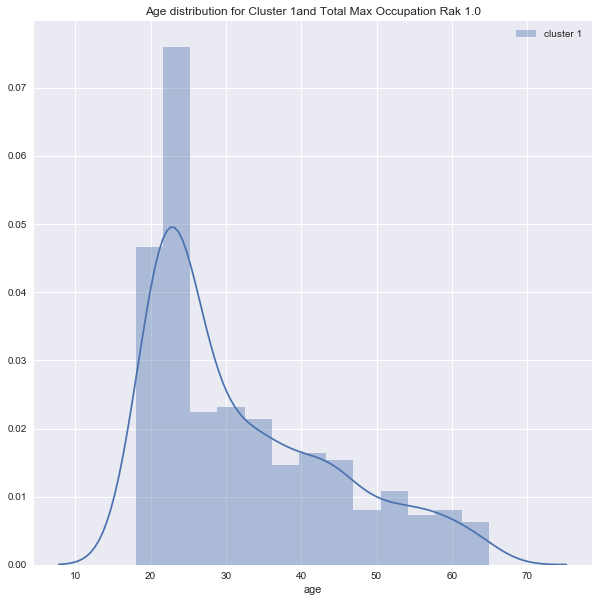

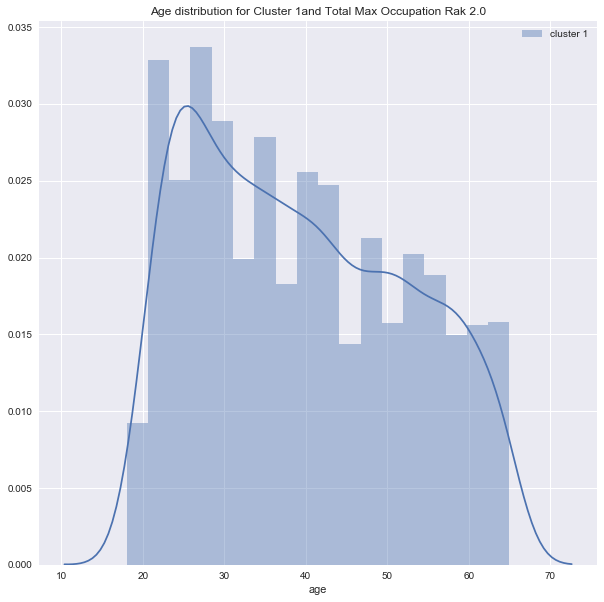

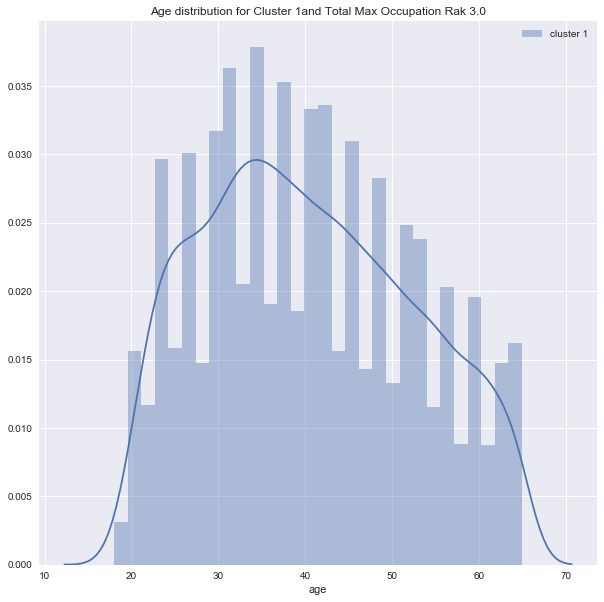

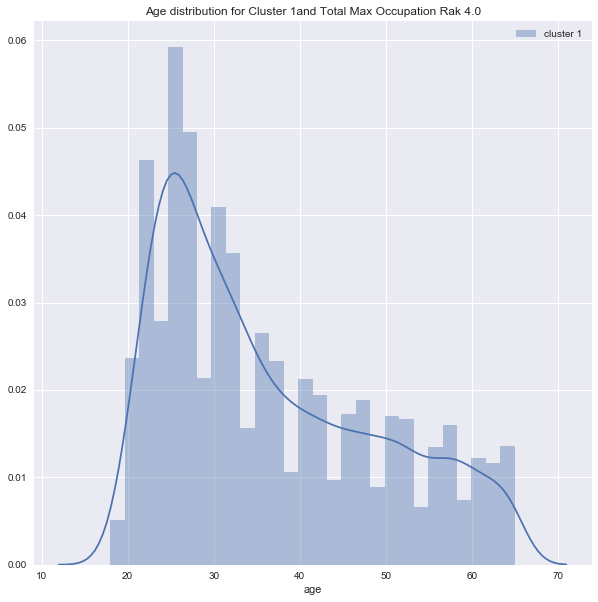

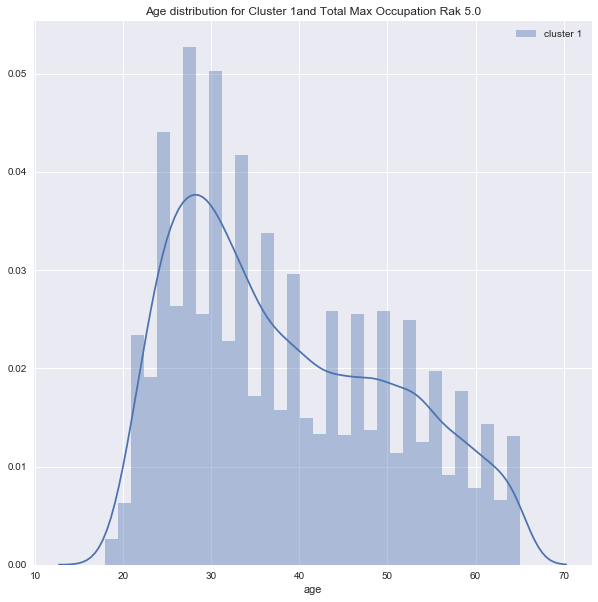

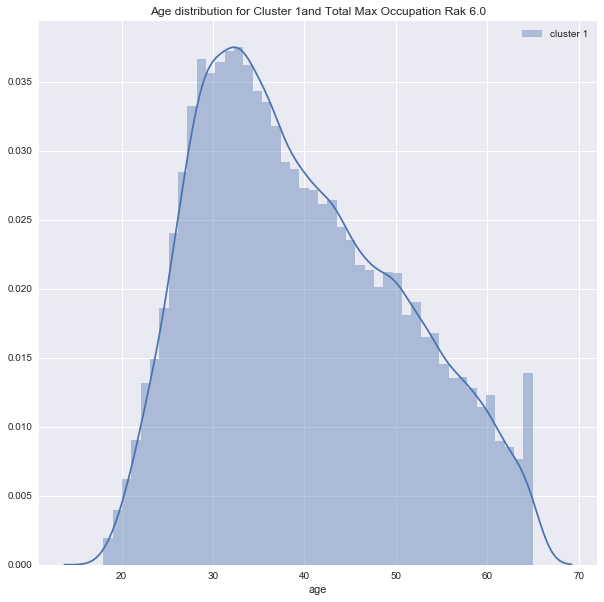

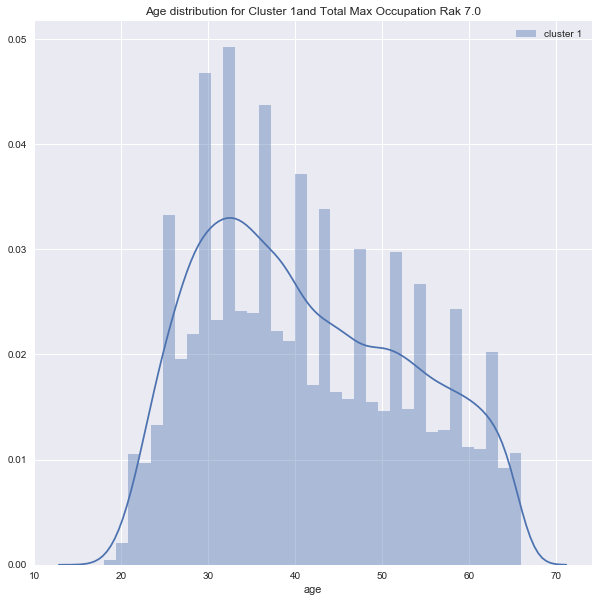

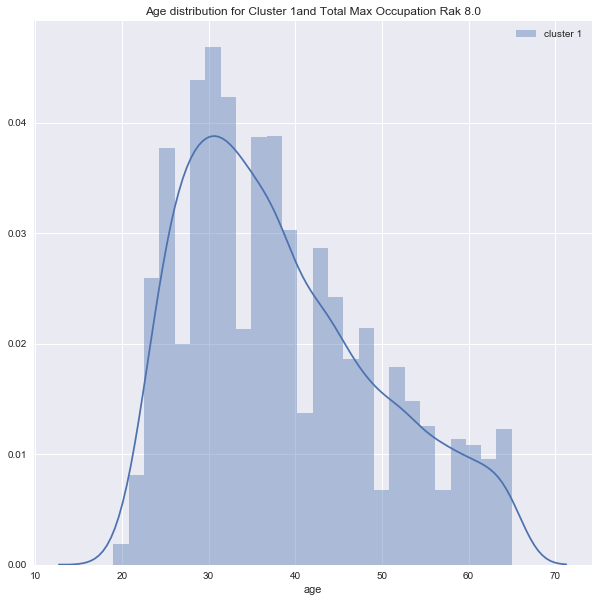

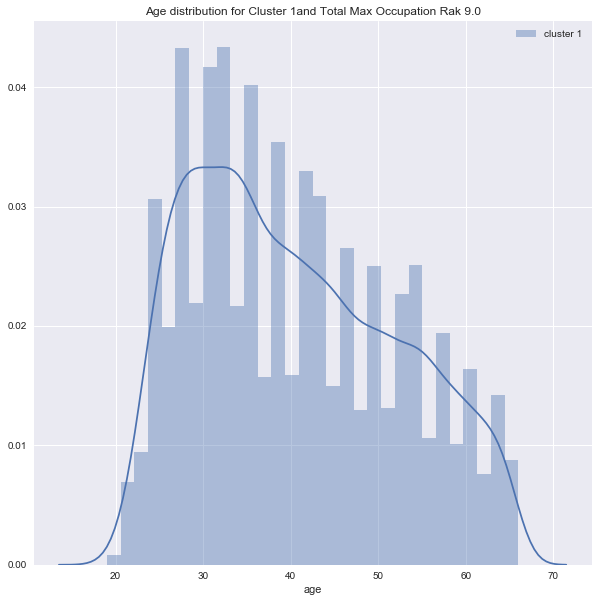

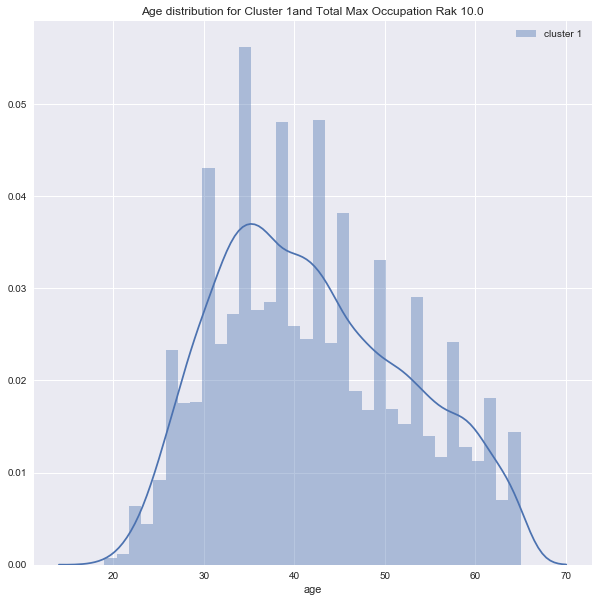

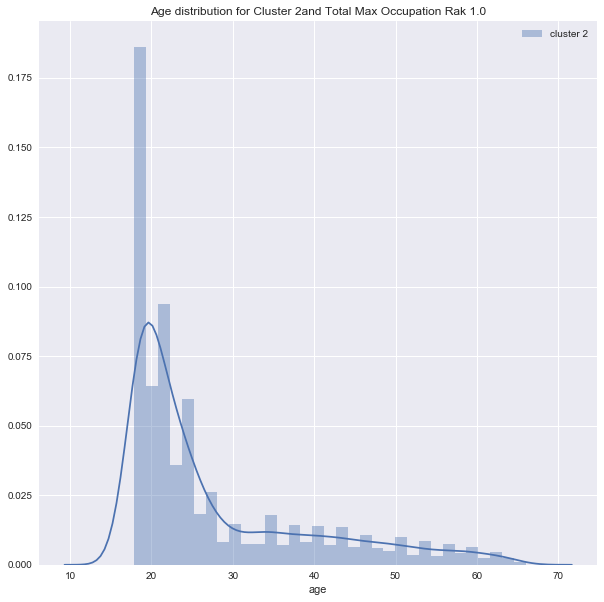

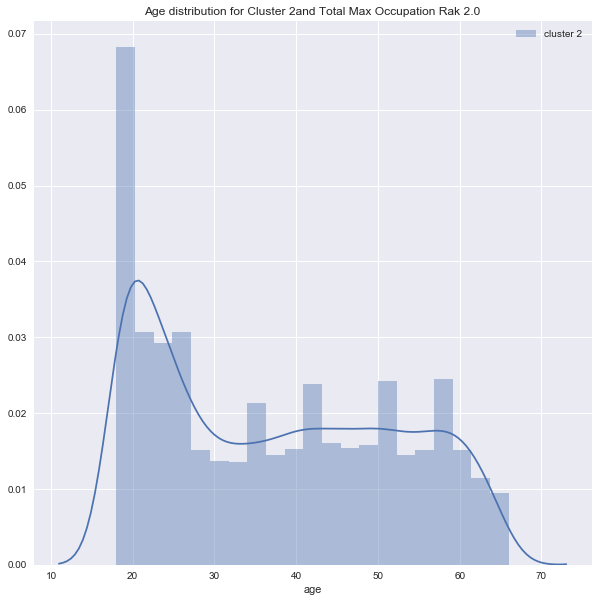

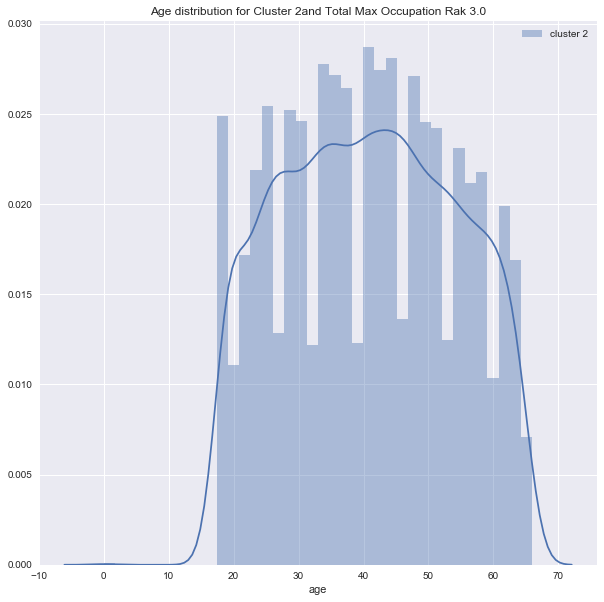

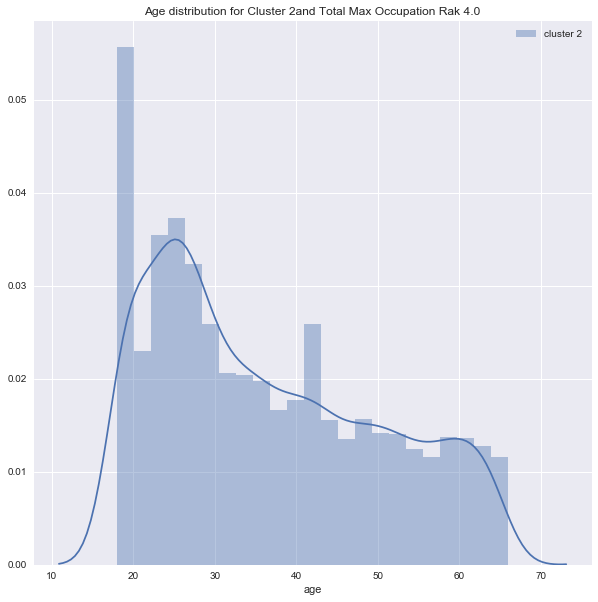

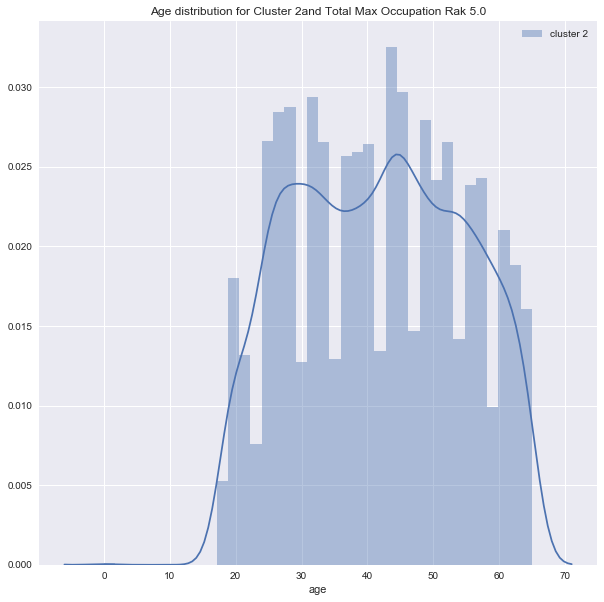

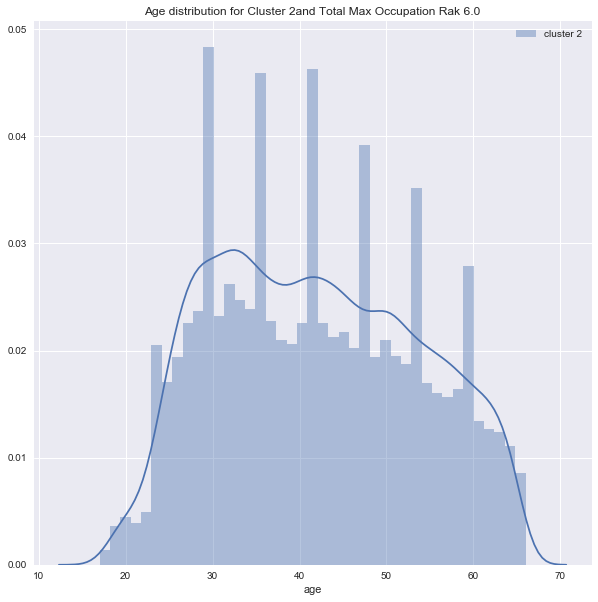

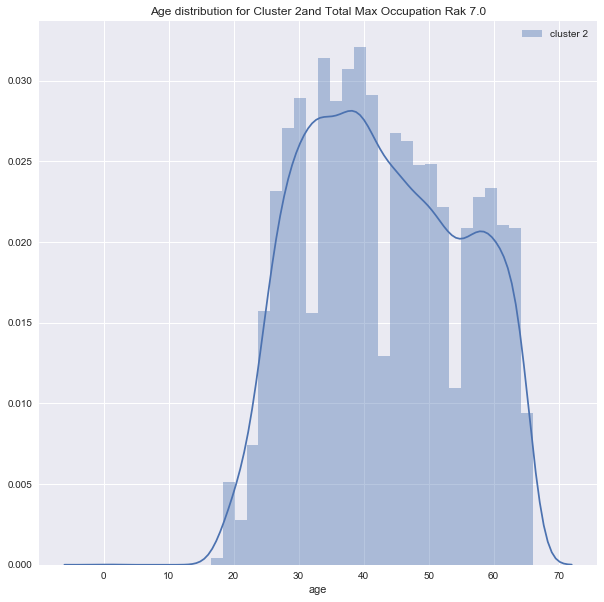

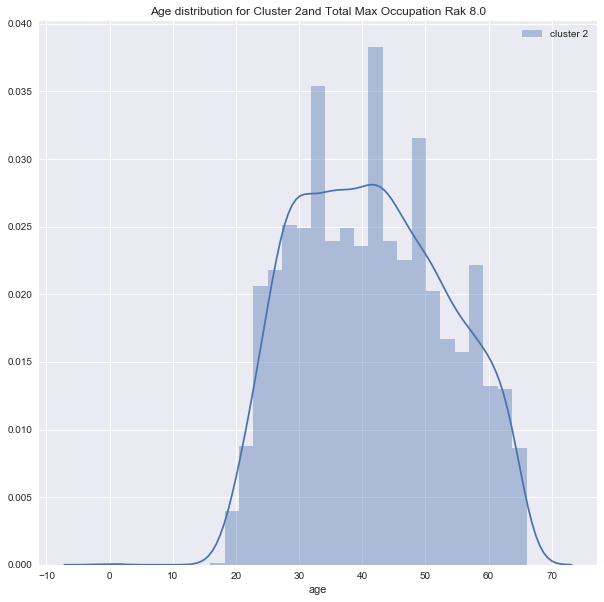

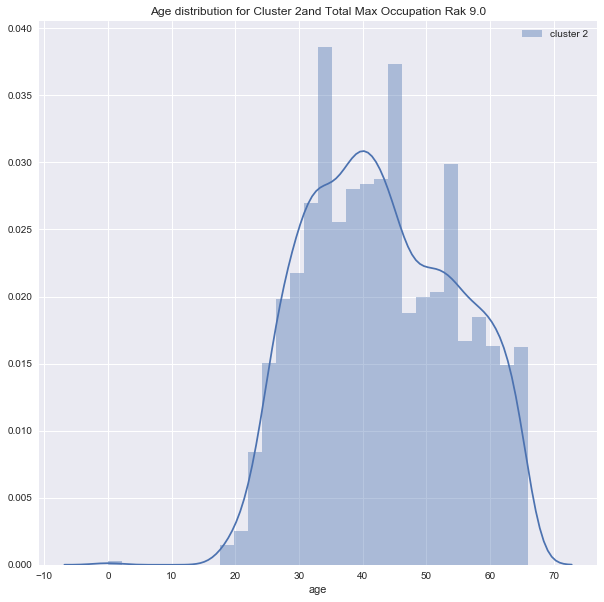

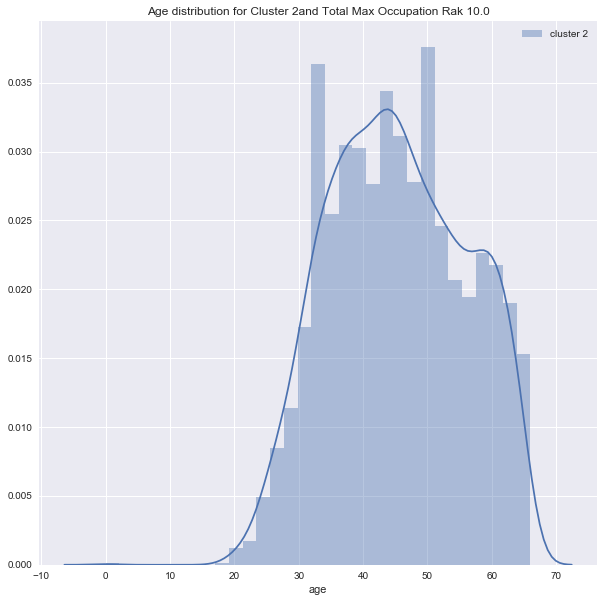

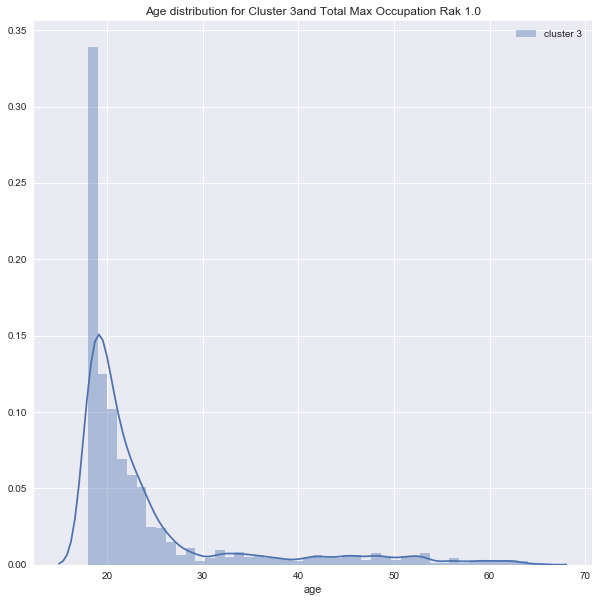

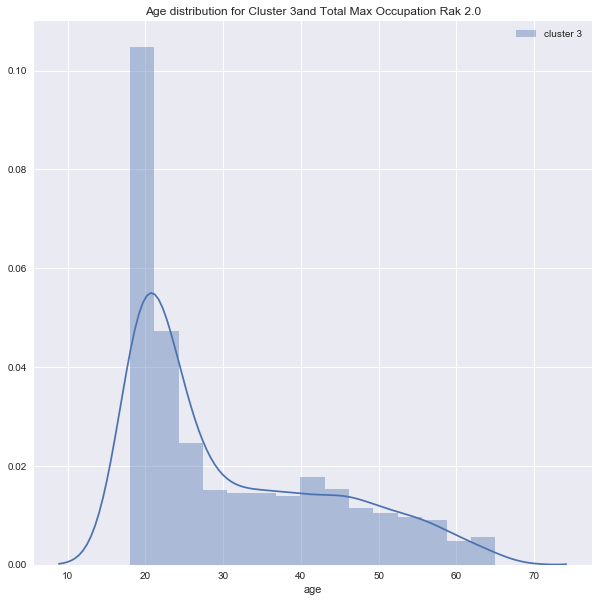

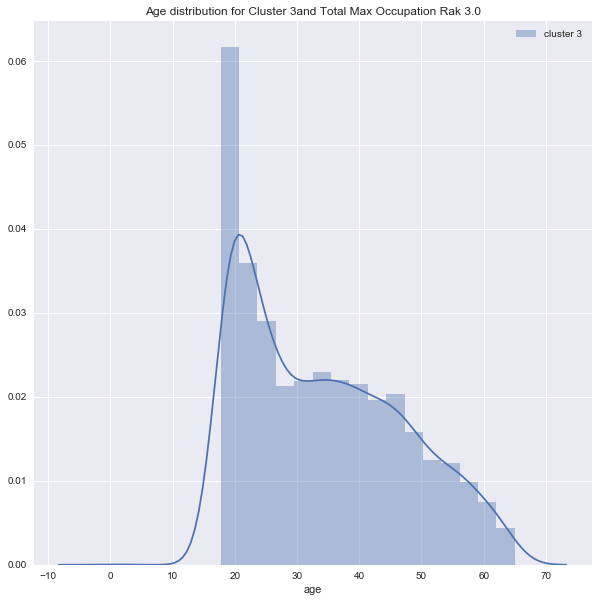

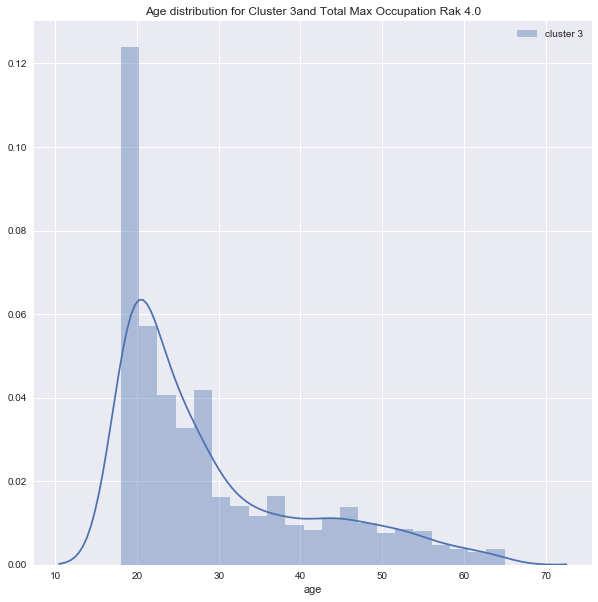

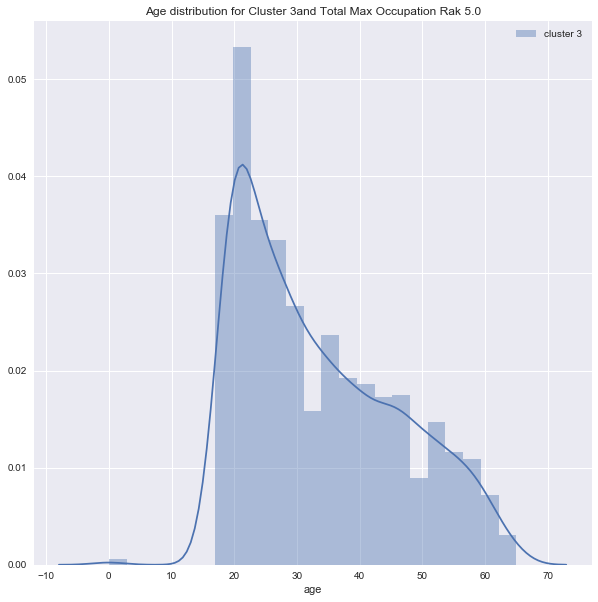

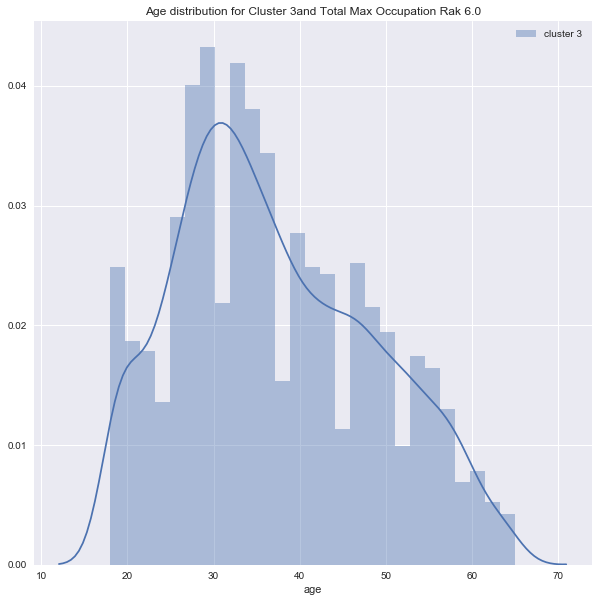

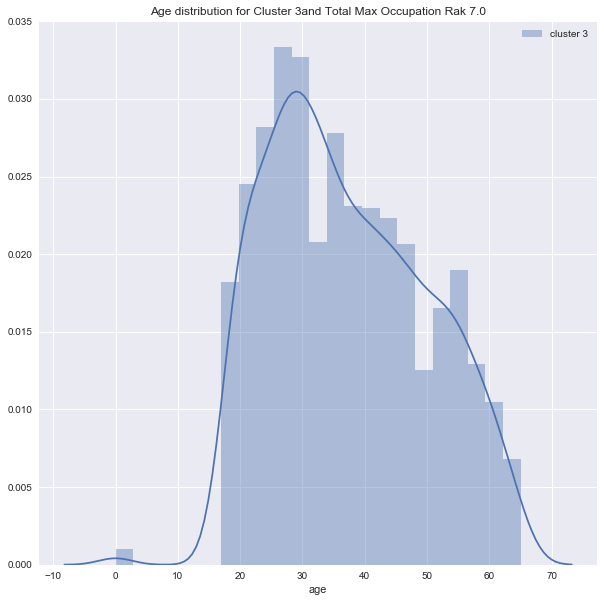

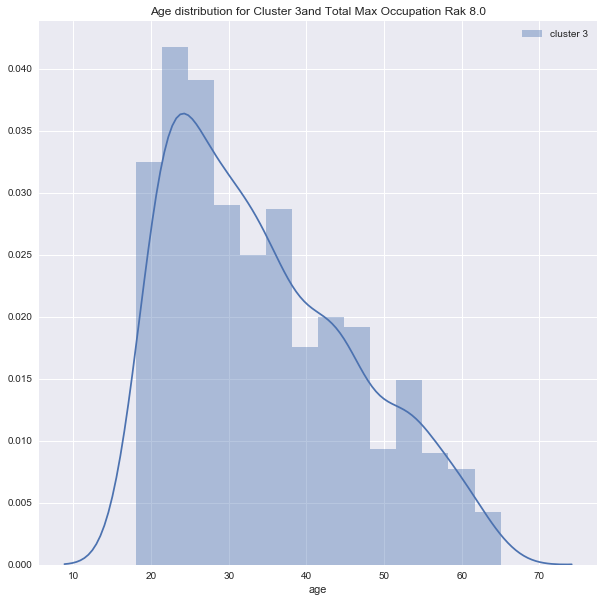

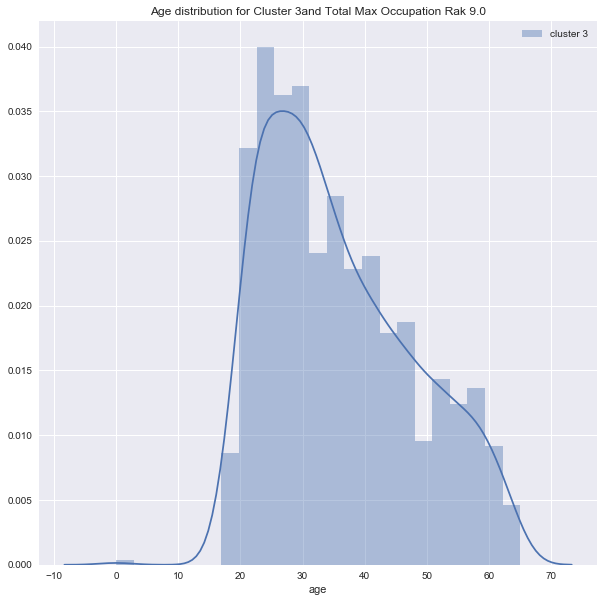

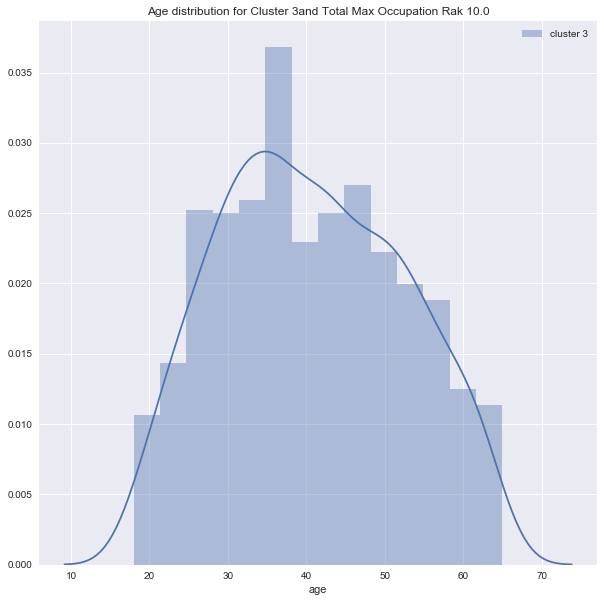

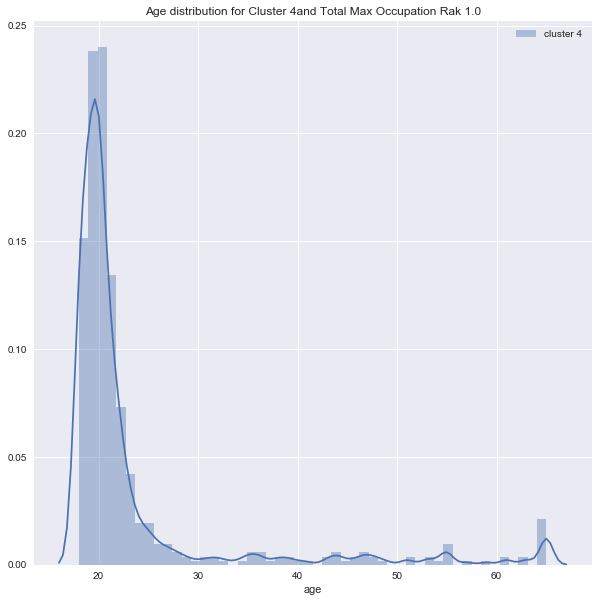

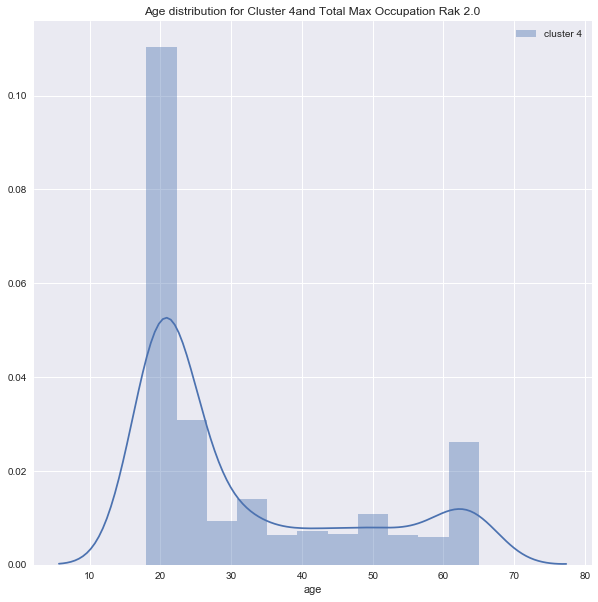

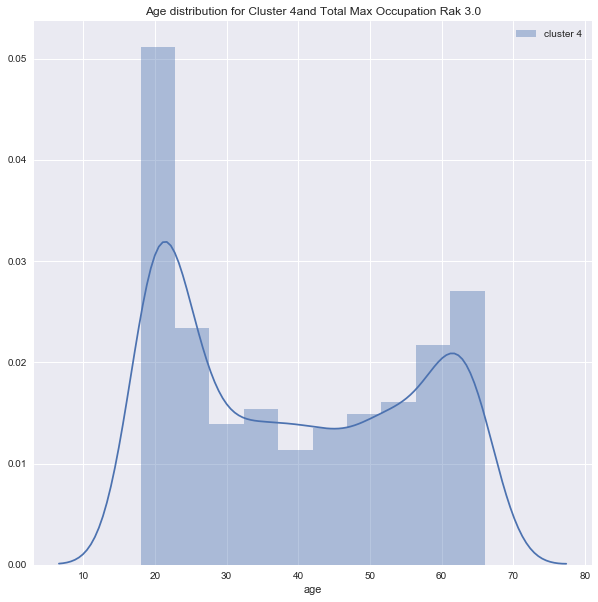

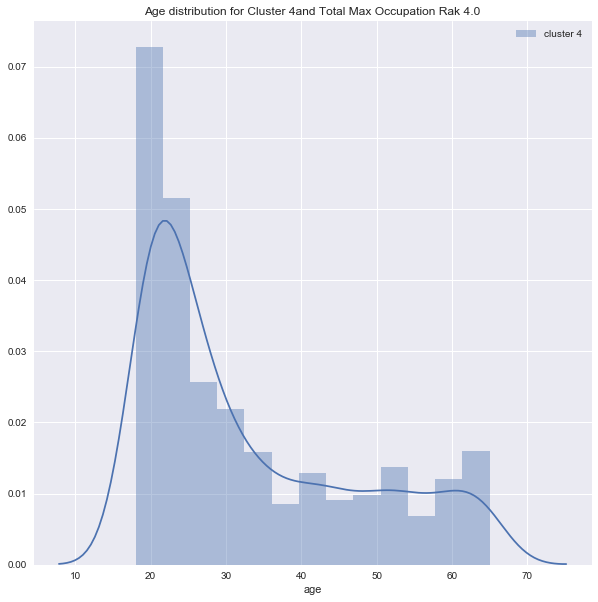

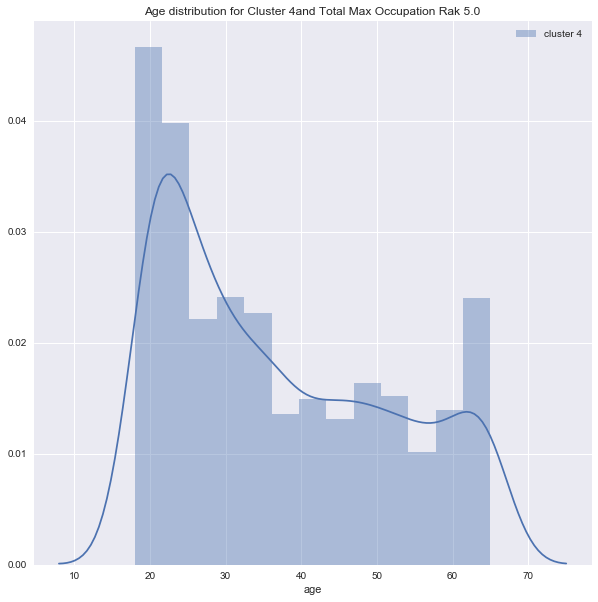

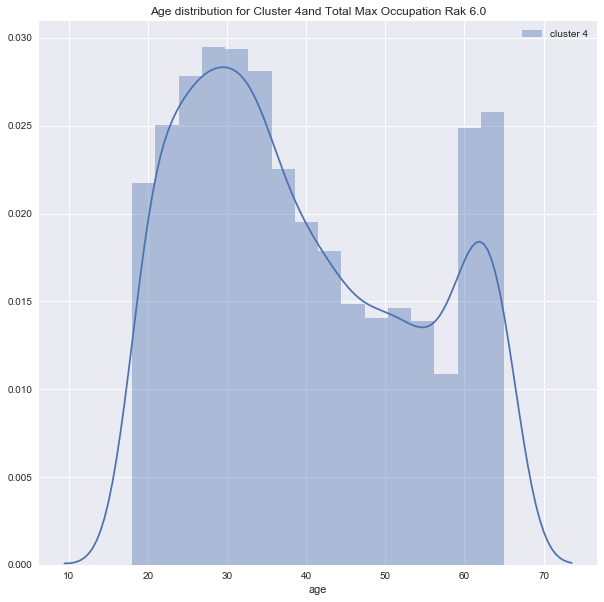

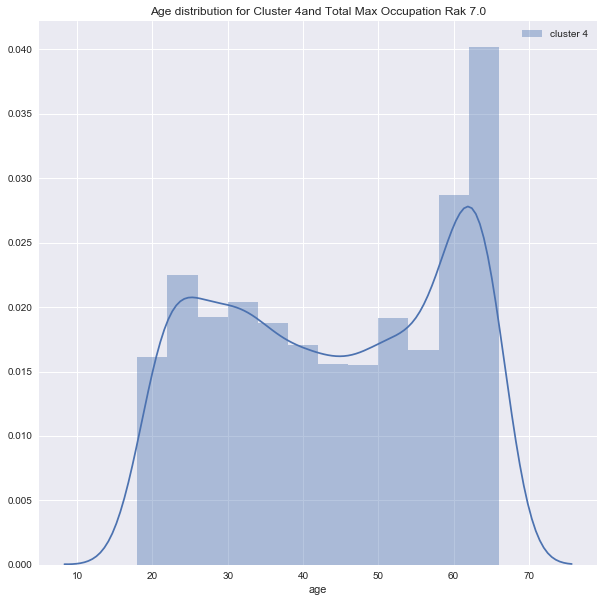

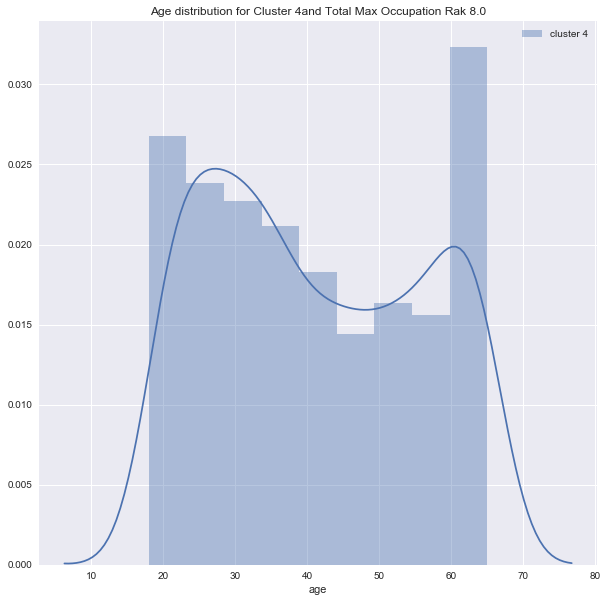

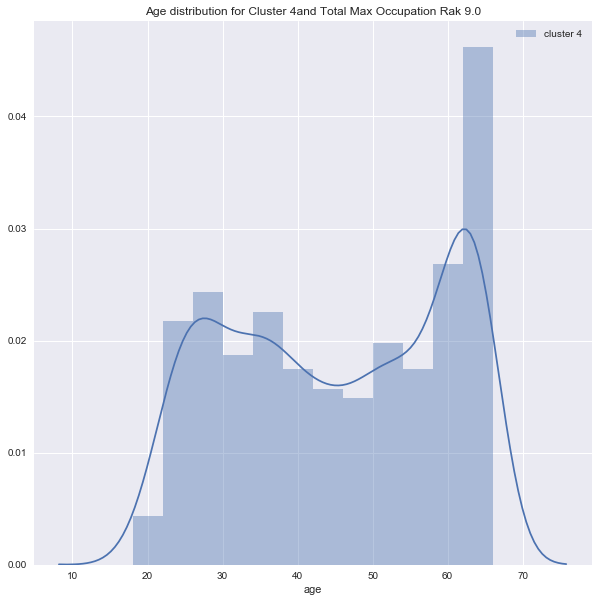

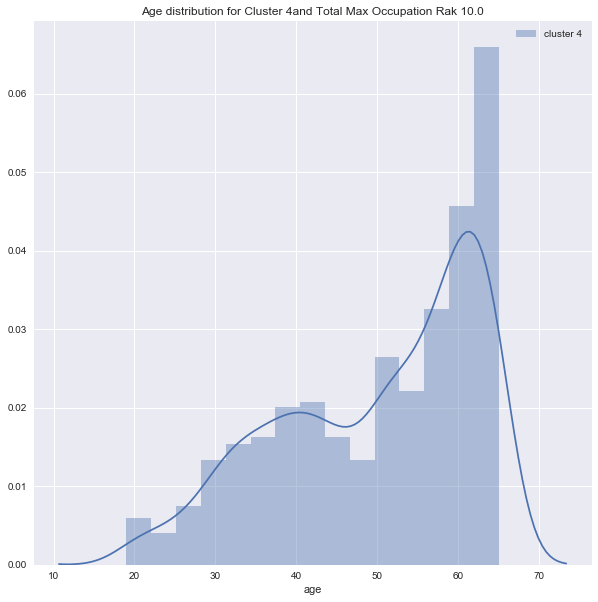

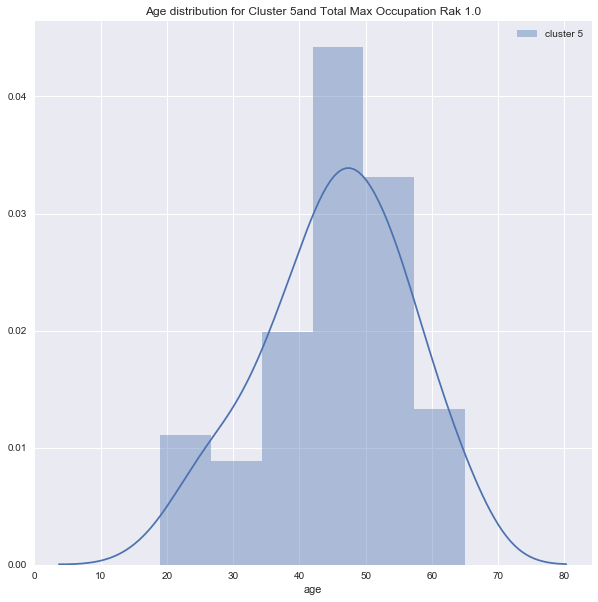

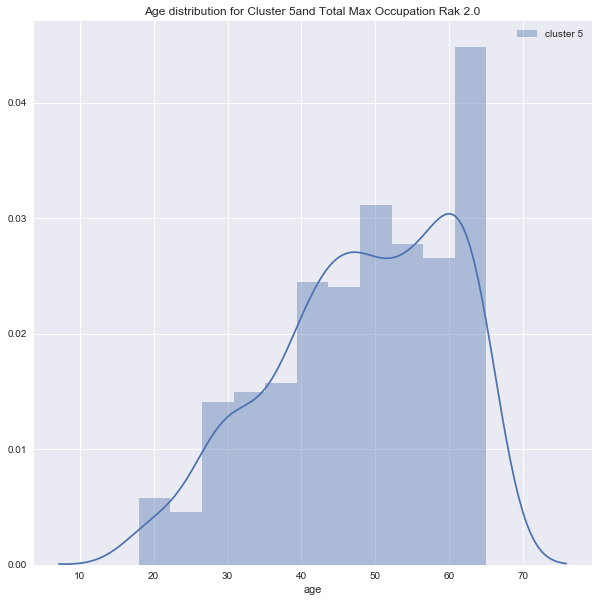

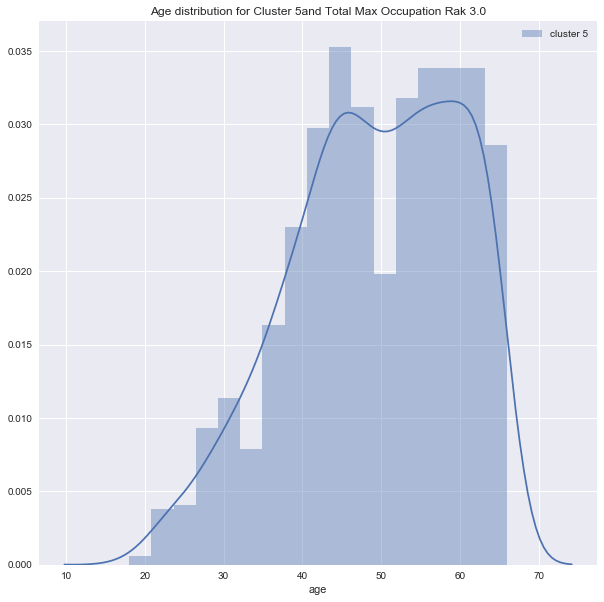

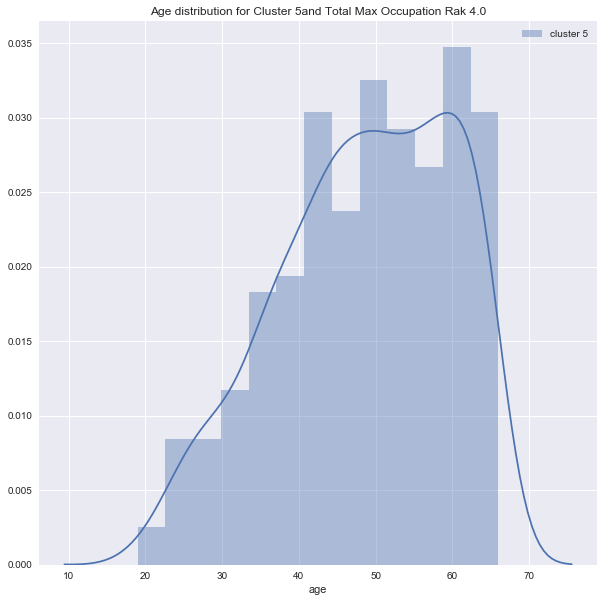

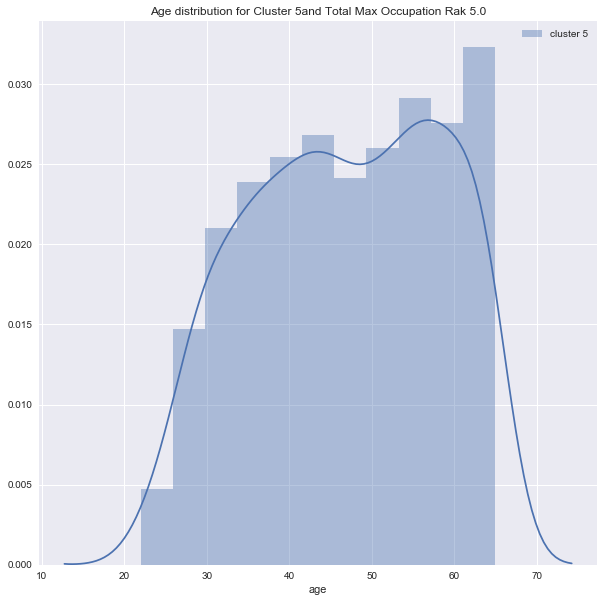

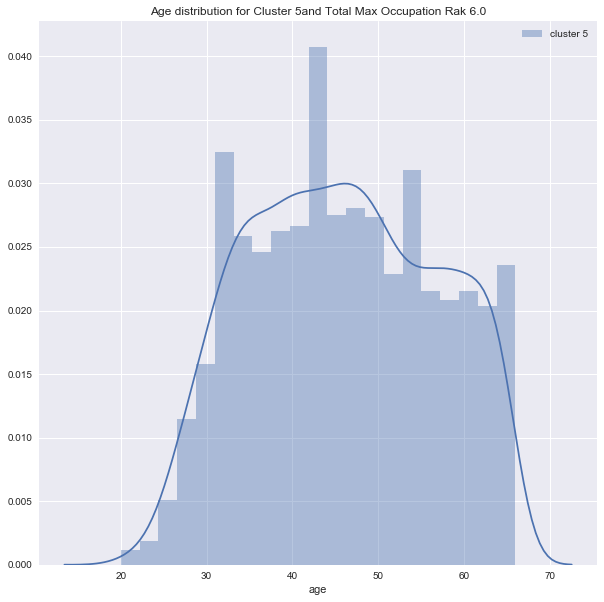

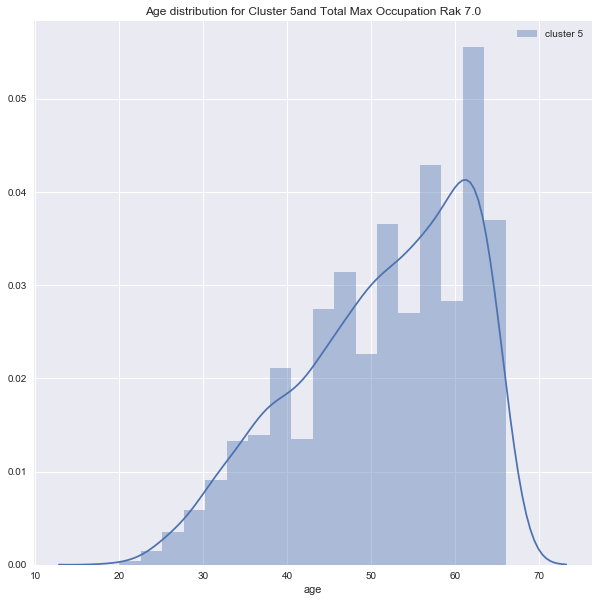

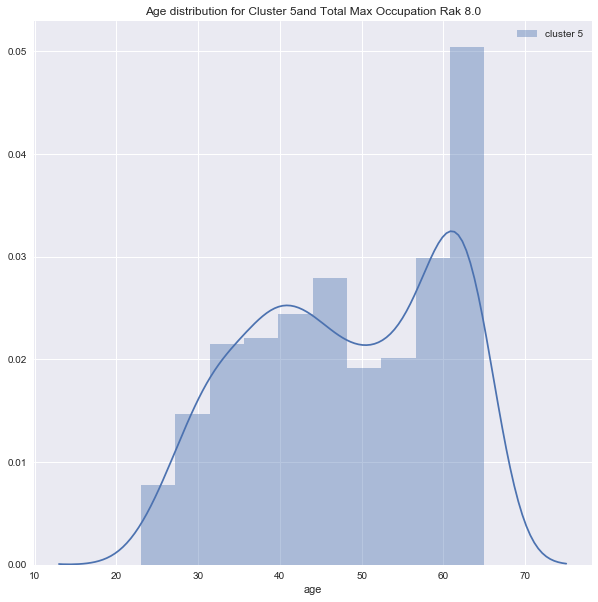

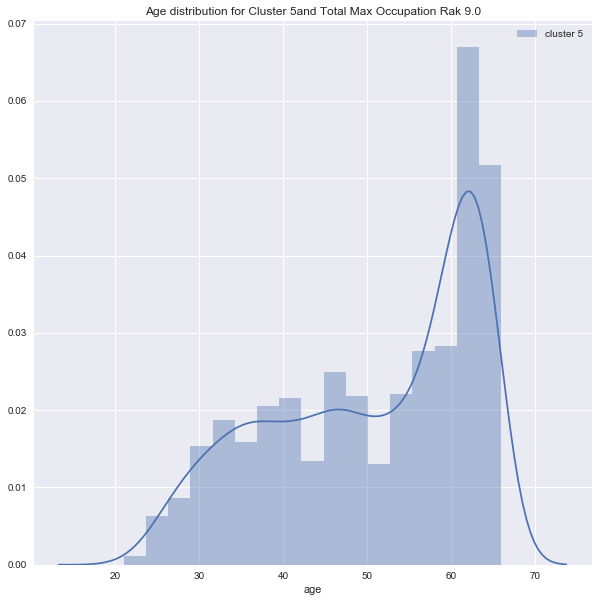

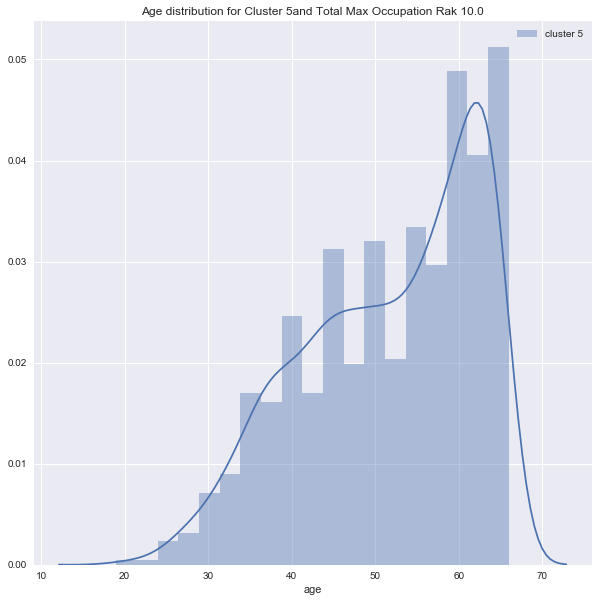

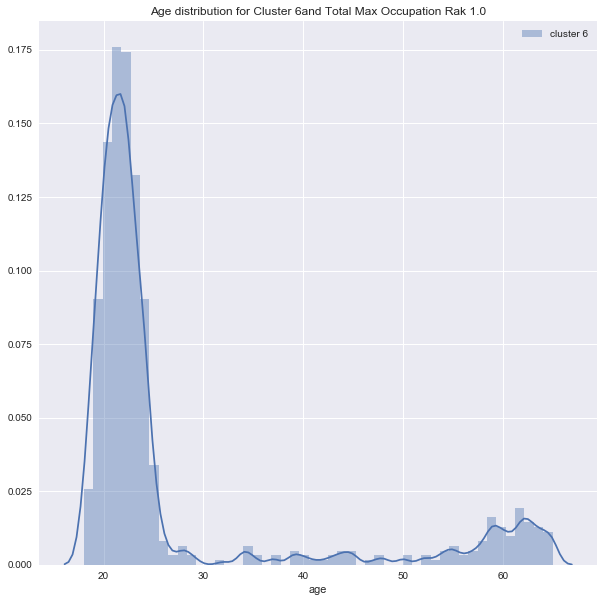

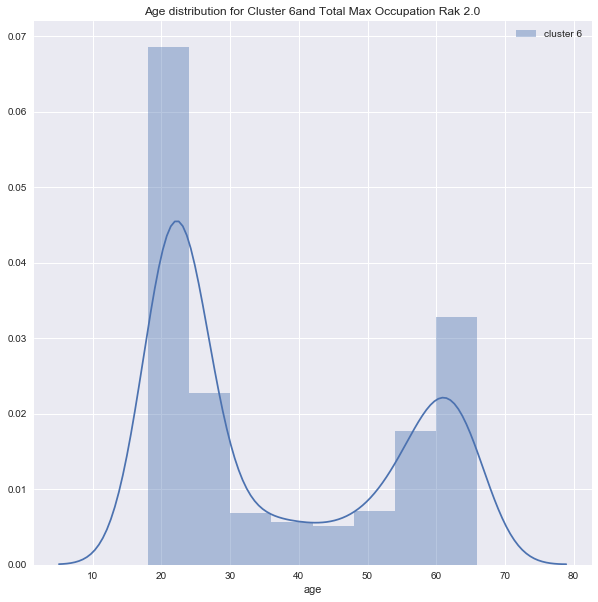

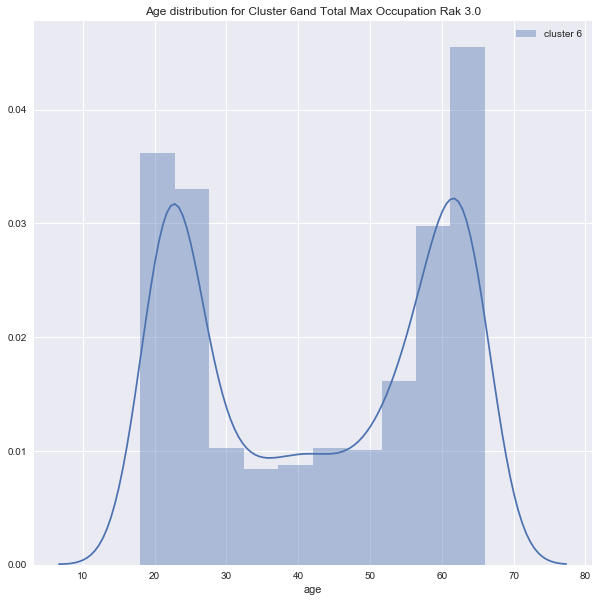

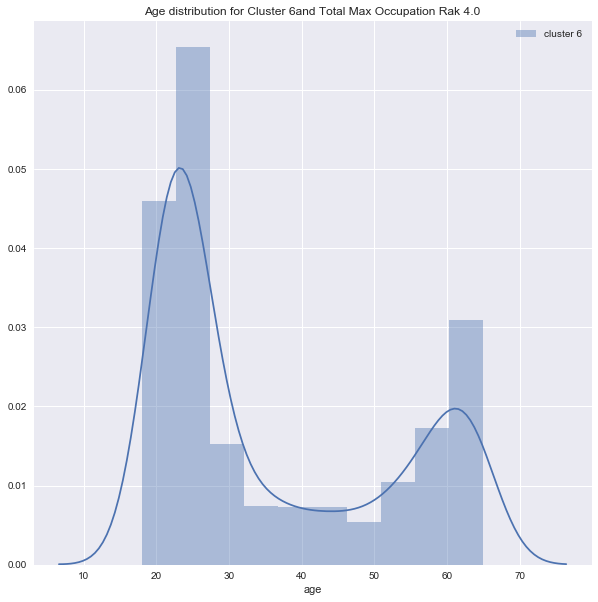

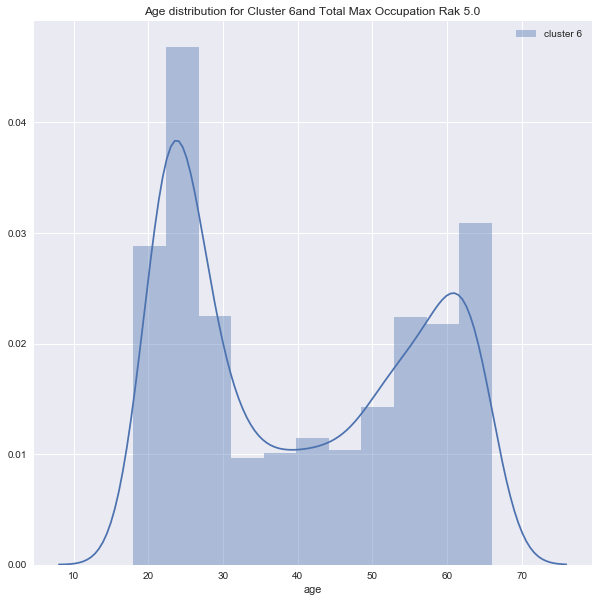

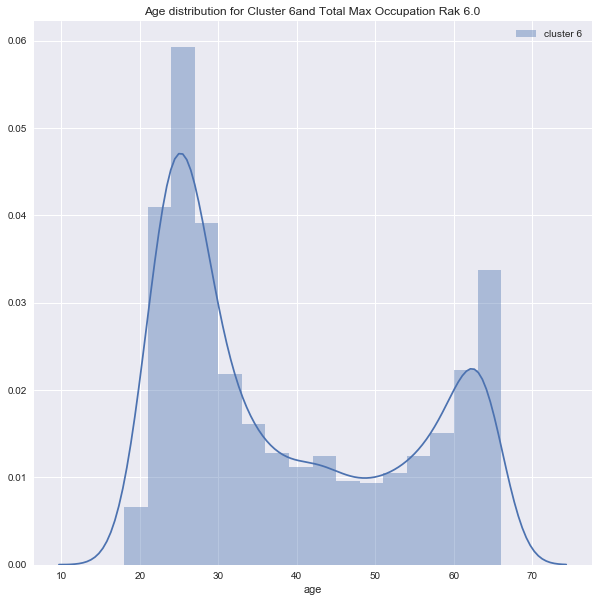

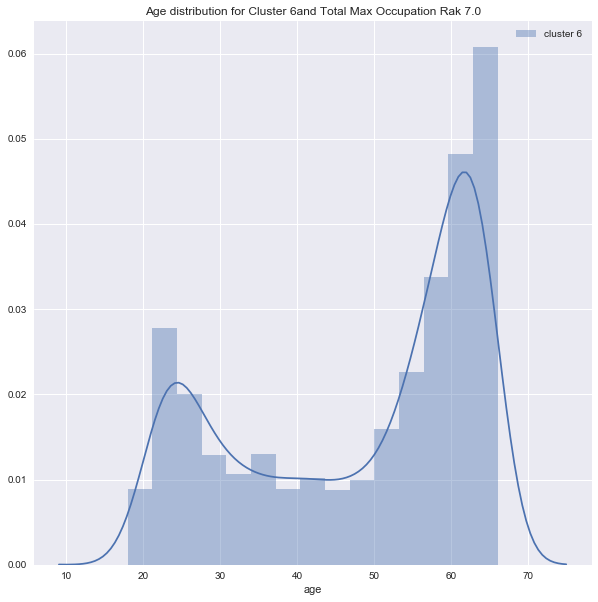

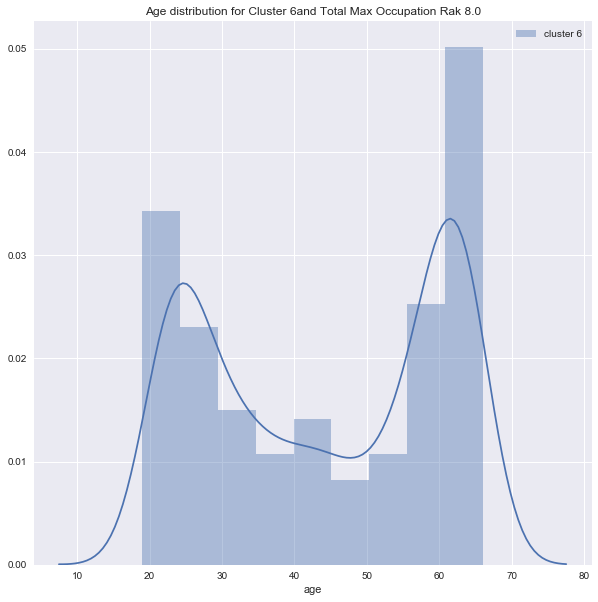

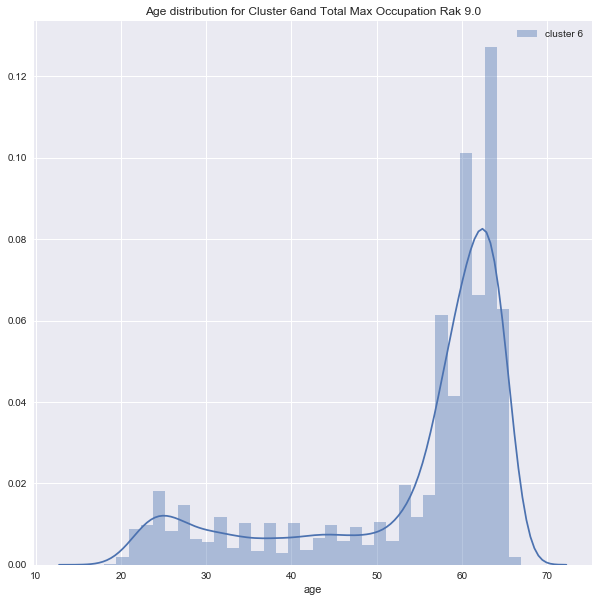

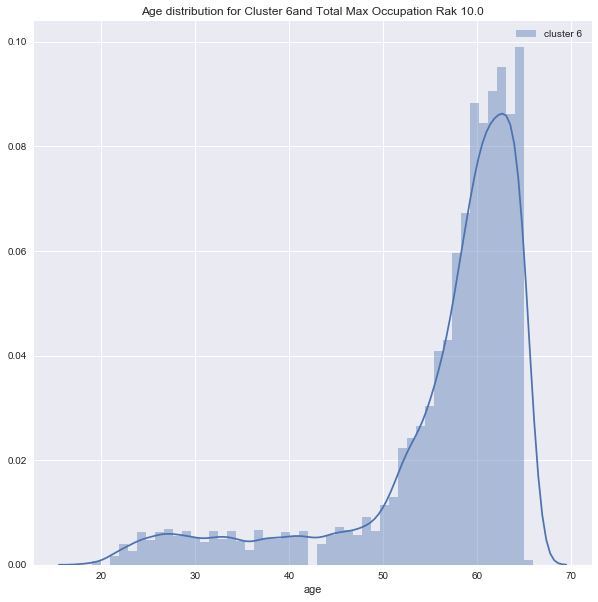

In [38]:
total_max_occupation_rank  = flatjld.total_max_occupation_rank.unique()
total_max_occupation_rank.sort()

clusters = flatjld.cluster.unique()
clusters.sort()

for c in clusters:
    for r in total_max_occupation_rank:
        data = flatjld.loc[(flatjld['cluster']  == c) & (flatjld['total_max_occupation_rank'] == r)]['age']
        plt.figure(figsize=(10,10))
        sns.distplot(data, label='cluster '+str(c))
        plt.title('Age distribution for Cluster ' + str(c) + 'and Total Max Occupation Rak ' + str(r) )
        plt.legend()
        plt.show()
